# Define MHWs using [Hobday definition](https://doi.org/10.1016/j.pocean.2015.12.014)
(>=5 consecutive days w/ a gap of >=3 days in between events for each grid cell)

|  | OISST | ERA5 | SPEAR-LO | SPEAR-HI |
| :---------- | :---------- | :----------: | ----------: | ----------: |
| Temperature | SST | SST | SST | SST |
| Sampling<br>frequency | Daily | Daily | Daily | Daily |
| Lat/Lon<br>resolution | 0.25˚ x 0.25˚ | 0.25˚ x 0.25˚ | 1˚ x 1˚ | 0.25˚ x 0.25˚ |
|Time period | 1981-09 : 2025-09 | 1983-01 : 2021-06 | 1981-09 : 2010-12 | 1991-01 : 2100-01 |

In [1]:
import xarray as xr
import pandas as pd
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.stats import linregress
from xrft import detrend
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import matplotlib.dates as mdates
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import geopandas as gpd
import regionmask
import gsw
import time
from tqdm import tqdm

In [2]:
#Use this ds as 'truth' when computing bias among all ens members
oisst = xr.open_mfdataset('/work/Shanice.Bailey/MHW-gfdl/OISST-*.nc', chunks={}, decode_times=True)

In [3]:
path = '/work5/stb/MHW-gfdl/era_subtropical.nc'
era5 = xr.open_mfdataset(path, chunks={}, decode_times=True)
era = era5.sst.sel(latitude=slice(None, 10))

In [4]:
era

<xarray.DataArray 'sst' (time: 16437, latitude: 85, longitude: 353)> Size: 4GB
dask.array<getitem, shape=(16437, 85, 353), dtype=float64, chunksize=(16437, 85, 353), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 1kB 262.0 262.2 262.5 ... 349.5 349.8 350.0
  * latitude   (latitude) float32 340B 31.0 30.75 30.5 30.25 ... 10.5 10.25 10.0
  * time       (time) datetime64[ns] 131kB 1980-01-01 1980-01-02 ... 2024-12-31

In [5]:
oisst

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 16206, lat: 84, lon: 328)
Coordinates:
  * time     (time) datetime64[ns] 130kB 1981-09-01 1981-09-02 ... 2026-01-13
  * lon      (lon) float32 1kB 262.1 262.4 262.6 262.9 ... 343.4 343.6 343.9
  * lat      (lat) float32 336B 10.12 10.38 10.62 10.88 ... 30.38 30.62 30.88
Data variables:
    sst      (time, lat, lon) float32 2GB dask.array<chunksize=(1, 84, 328), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 1.9.10 (https://mpimet.mpg...
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    institution:    NOAA/NCDC
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...
    CDO:            Climate Data Operators version 1.9.10 (https://mpimet.mpg...
    history:        15-Jan-2026 09:24:28 Subset NOAA/PSL

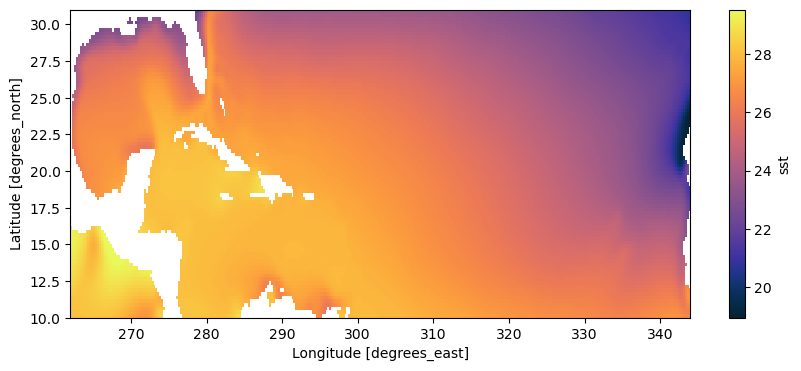

/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [6]:
oisst.sst.mean('time').plot(figsize=(10,4), cmap=cmocean.cm.thermal)

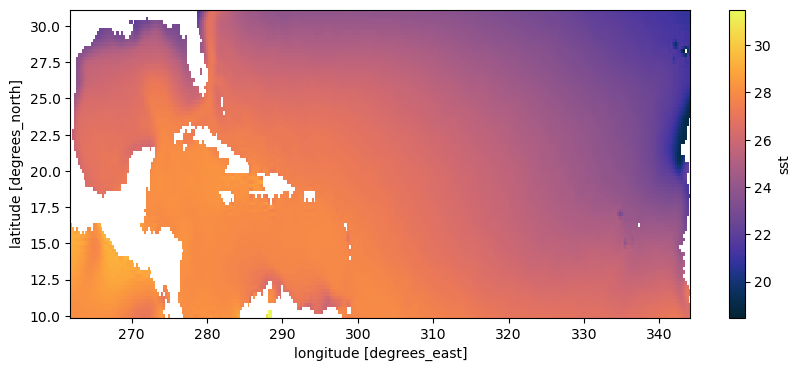

In [7]:
era.sel(longitude=slice(None, 344)).mean('time').plot(figsize=(10,4), cmap=cmocean.cm.thermal)

In [4]:
%%time 
#Open all the ensemble members as a list of datasets to run mhw detection function over them as a loop
#zfill pads single ints w 0's to the left
formatted_list = [str(i).zfill(2) for i in range(1, 31)]
ens_lds = [] #list of the ds'
for ens_num in tqdm(formatted_list):
    ens_lds.append(xr.open_mfdataset(f'/work/Veeshan.Narinesingh/SPEAR_LO/ENS_{ens_num}/ice_daily.*.SST.nc',
                                     decode_timedelta=True).rename_vars({'SST': f'SST_ens{ens_num}'}))
    time.sleep(0.01)

100%|██████████| 30/30 [16:29<00:00, 32.97s/it]

CPU times: user 3.22 s, sys: 15.4 s, total: 18.7 s
Wall time: 16min 29s


In [5]:
len(ens_lds)

30

In [6]:
ens_lds[2]

<xarray.Dataset> Size: 5GB
Dimensions:     (time: 10957, yT: 320, xT: 360, nv: 2, xTe: 361, yTe: 321)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
  * time        (time) object 88kB 1981-01-01 12:00:00 ... 2010-12-31 12:00:00
  * xT          (xT) float64 3kB -299.5 -298.5 -297.5 -296.5 ... 57.5 58.5 59.5
  * xTe         (xTe) float64 3kB -300.0 -299.0 -298.0 -297.0 ... 58.0 59.0 60.0
  * yT          (yT) float64 3kB -77.77 -77.56 -77.34 ... 89.48 89.69 89.9
  * yTe         (yTe) float64 3kB -77.88 -77.67 -77.45 ... 89.59 89.8 90.0
Data variables:
    SST_ens03   (time, yT, xT) float32 5GB dask.array<chunksize=(3652, 320, 360), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] 88kB dask.array<chunksize=(3652,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] 88kB dask.array<chunksize=(3652,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] 88kB dask.array<chunksize=(3652,), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] 175kB dask.array<chunksize=(3652, 2), meta=np.ndarray>
Attributes:
    filename:   ice_daily.19810101-19901231.SST.nc
    title:      SPEAR_c96_o1_Hist_AllForc_IC1851_K50_ens_01_05
    grid_type:  regular
    grid_tile:  N/A

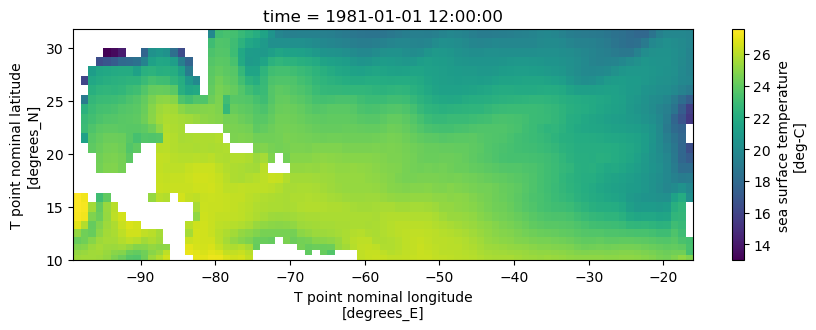

In [8]:
carib = dict(yT=slice(10, 31.5), xT=slice(-99,-16))
ens_lds[0].SST_ens01[0].sel(**carib).plot(figsize=(10,3))

In [9]:
ens_lda_carib = [ens_lds[i][f'SST_ens{ens_num}'].sel(**carib) for (i, ens_num) in zip(np.arange(0, len(ens_lds)), 
                                                                                      formatted_list)]

In [10]:
ens_lda_carib[:3]

[<xarray.DataArray 'SST_ens01' (time: 10957, yT: 26, xT: 83)> Size: 95MB
 dask.array<getitem, shape=(10957, 26, 83), dtype=float32, chunksize=(3653, 26, 83), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) object 88kB 1981-01-01 12:00:00 ... 2010-12-31 12:00:00
   * xT       (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
   * yT       (yT) float64 208B 10.2 10.67 11.22 11.85 ... 29.59 30.46 31.31
 Attributes:
     long_name:      sea surface temperature
     units:          deg-C
     cell_methods:   time: mean
     time_avg_info:  average_T1,average_T2,average_DT,
 <xarray.DataArray 'SST_ens02' (time: 10957, yT: 26, xT: 83)> Size: 95MB
 dask.array<getitem, shape=(10957, 26, 83), dtype=float32, chunksize=(3653, 26, 83), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) object 88kB 1981-01-01 12:00:00 ... 2010-12-31 12:00:00
   * xT       (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
   * yT       (yT) float64 208B 10.2 10.67 11.2

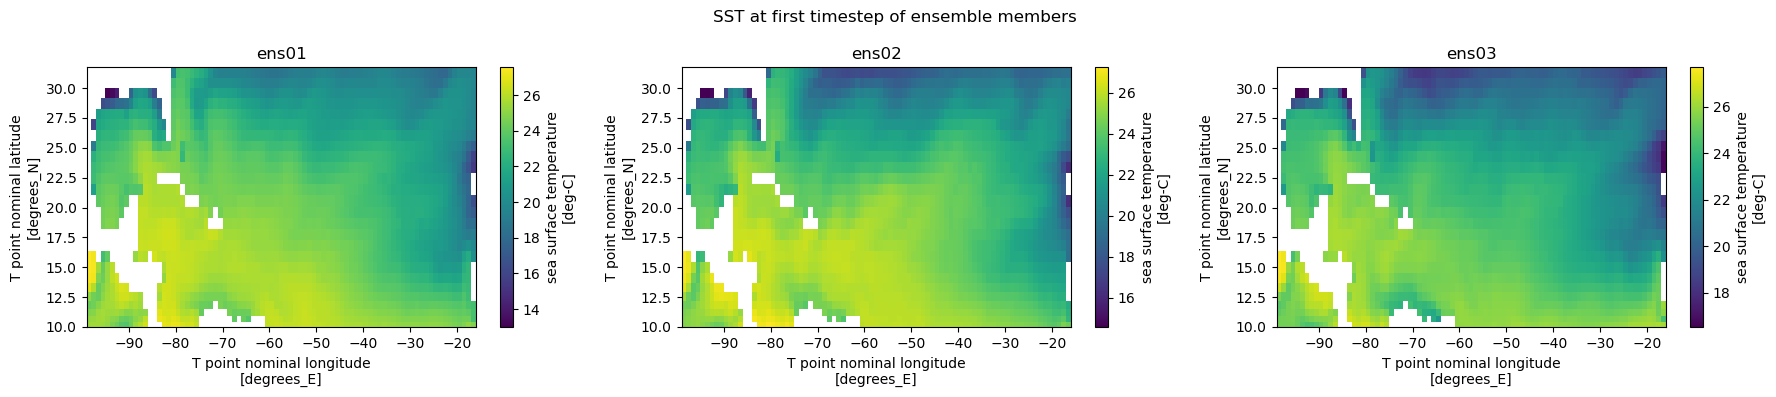

In [11]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
for i,j in zip(ens_lda_carib[:3], np.arange(0,3)):
    i.isel(time=0).plot(ax=ax[j])
    ax[j].set_title(f'{i.name[4:]}')
plt.suptitle('SST at first timestep of ensemble members')
plt.tight_layout();

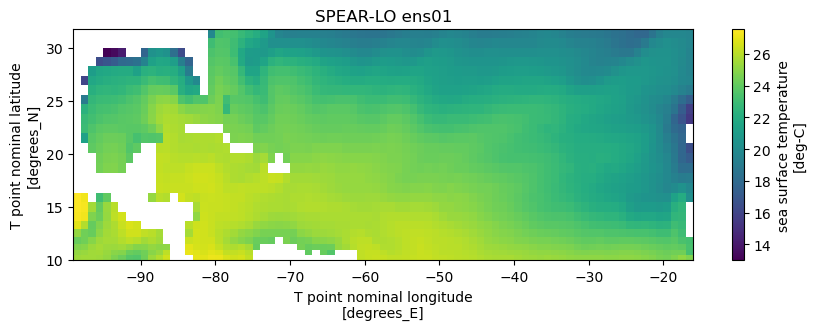

In [16]:
ens_lda_carib[0][0].plot(figsize=(10,3))
plt.title(f'SPEAR-LO {ens_lda_carib[0][0].name[4:]}');

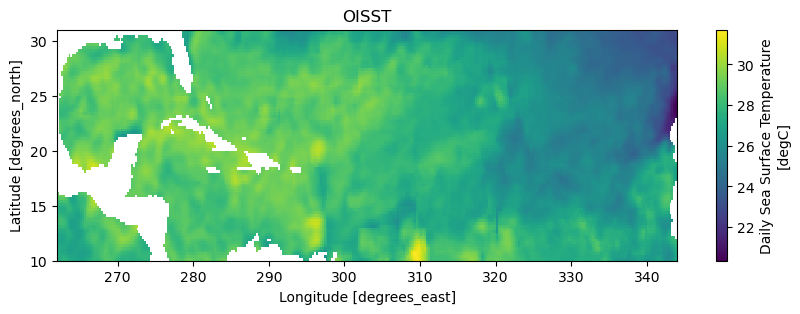

In [13]:
oisst.sst[0].plot(figsize=(10,3))
plt.title('OISST');

## Manual Detection

|  | OISST | CORA | GLORYS | ERA5 | SPEAR |
| :----------: | :----------: | :----------: | :----------: | :----------: | :----------: |
| Temperature | SST | 3D | 3D | SST |
| Sampling<br>frequency | Daily | Monthly | Monthly | Daily |   |
| Lat/Lon<br>resolution | 0.25˚ x 0.25˚ | 0.1˚ x 0.5˚ | 1/12˚ x 1/12˚ | 0.25˚ x 0.25˚ |   |
|Time period | 1981-09 : 2025-09 | 1980-01 : 2024-06 | 1993-01 : 2025-08 | 1983-01 : 2021-06 |   |

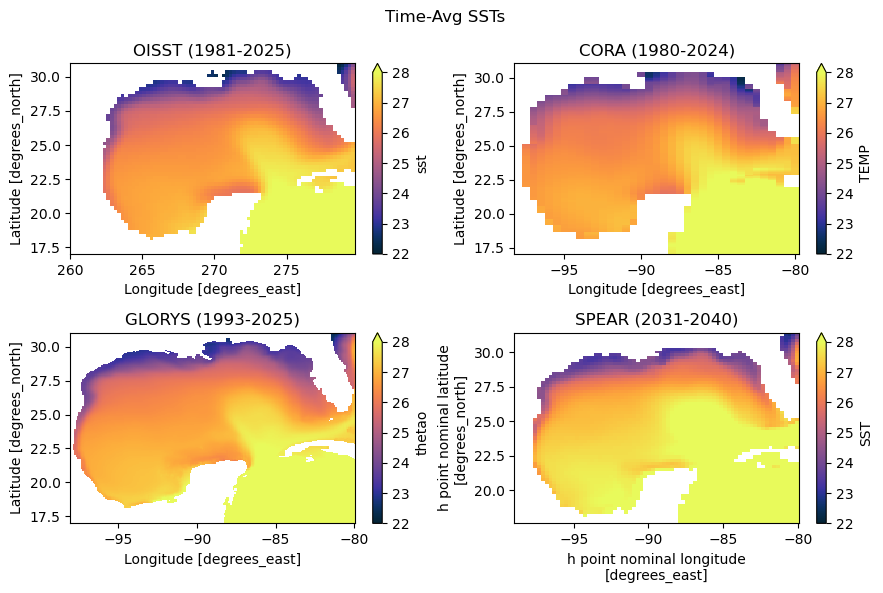

In [27]:
fig, ax = plt.subplots(2,2, figsize=(9,6))
oisst.mean('time').plot(ax=ax[0,0], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[0,0].set_title('OISST (1981-2025)')
cora.TEMP.isel(depth=0).mean('time').plot(ax=ax[0,1], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[0,1].set_title('CORA (1980-2024)')
glorys_ds.thetao.isel(depth=0).mean('time').plot(ax=ax[1,0], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[1,0].set_title('GLORYS (1993-2025)')
#era.sst.mean('time').plot(ax=ax[1,1], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
spear.mean('time').plot(ax=ax[1,1], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[1,1].set_title('SPEAR (2031-2040)')
plt.suptitle('Time-Avg SSTs')
plt.tight_layout();

## Detrend

In [12]:
def detrend_func(da):
    #Fits a polynomial to the data along the time dim
    #solves for the polynomial coefficients (slope + intercept) at each (lat, lon) point.
    p = da.polyfit(dim='time', deg=1) #('degree', 'lat', 'lon')
    #evaluates that polynomial at da.time
    fit = xr.polyval(da.time, p.polyfit_coefficients) #('time', 'lat','lon')
    #detrended da along time dim 
    detrended_intime = da - fit
    #w mean added back in to get intuitive values in ˚C
    detrended_wmean = da - fit + da.mean(dim='time')
    # compute local variability
    std = detrended_intime.std(dim='time')
    # standardized anomalies
    #Shows where anomalies are most extreme relative to local variability
    detrended_std = detrended_intime / std

    return fit, detrended_intime

In [8]:
seasonal_cycle_oisst = oisst.sst.groupby("time.month").mean("time") 
oisst_anom = oisst.sst.groupby("time.month") - seasonal_cycle_oisst
fit_oisst, detrended_intime_oisst = detrend_func(oisst_anom)

In [9]:
seasonal_cycle_era = era.sel(longitude=slice(None, 344)).groupby("time.month").mean("time") 
era_anom = era.sel(longitude=slice(None, 344)).groupby("time.month") - seasonal_cycle_era
fit_era, detrended_intime_era = detrend_func(era_anom)

In [13]:
fit_spear_lo = []
detrended_intime_spear_lo = []

for da in ens_lda_carib:
    seasonal_cycle = da.groupby('time.month').mean('time')
    da_anom = da.groupby('time.month') - seasonal_cycle
    fit_sl, detrended_sl = detrend_func(da_anom)
    fit_spear_lo.append(fit_sl)
    detrended_intime_spear_lo.append(detrended_sl)

In [10]:
detrended_intime_oisst

<xarray.DataArray (time: 16206, lat: 84, lon: 328)> Size: 4GB
dask.array<sub, shape=(16206, 84, 328), dtype=float64, chunksize=(1, 84, 328), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 130kB 1981-09-01 1981-09-02 ... 2026-01-13
  * lon      (lon) float32 1kB 262.1 262.4 262.6 262.9 ... 343.4 343.6 343.9
  * lat      (lat) float32 336B 10.12 10.38 10.62 10.88 ... 30.38 30.62 30.88
    month    (time) int64 130kB 9 9 9 9 9 9 9 9 9 9 9 ... 1 1 1 1 1 1 1 1 1 1 1

In [38]:
detrended_intime_spear_lo[0]

<xarray.DataArray (time: 10957, yT: 26, xT: 83)> Size: 189MB
dask.array<sub, shape=(10957, 26, 83), dtype=float64, chunksize=(3653, 26, 83), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 88kB 1981-01-01 12:00:00 ... 2010-12-31 12:00:00
  * xT       (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
  * yT       (yT) float64 208B 10.2 10.67 11.22 11.85 ... 29.59 30.46 31.31

In [14]:
fit_spear_lo[0].time

<xarray.DataArray 'time' (time: 10957)> Size: 88kB
array([cftime.DatetimeJulian(1981, 1, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1981, 1, 2, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1981, 1, 3, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeJulian(2010, 12, 29, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2010, 12, 30, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2010, 12, 31, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 88kB 1981-01-01 12:00:00 ... 2010-12-31 12:00:00
    month    (time) int64 88kB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   JULIAN
    bounds:          time_bnds

In [43]:
fit_oisst.time

<xarray.DataArray 'time' (time: 16206)> Size: 130kB
array(['1981-09-01T00:00:00.000000000', '1981-09-02T00:00:00.000000000',
       '1981-09-03T00:00:00.000000000', ..., '2026-01-11T00:00:00.000000000',
       '2026-01-12T00:00:00.000000000', '2026-01-13T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 130kB 1981-09-01 1981-09-02 ... 2026-01-13
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T
    actual_range:   [66352. 73657.]

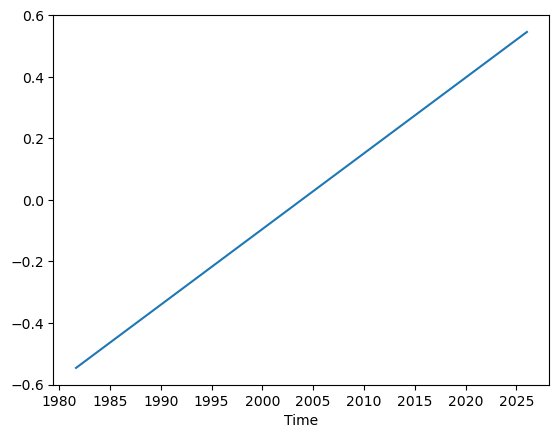

In [11]:
fit_oisst.mean(['lat','lon']).plot(label='OISST-anom fit')

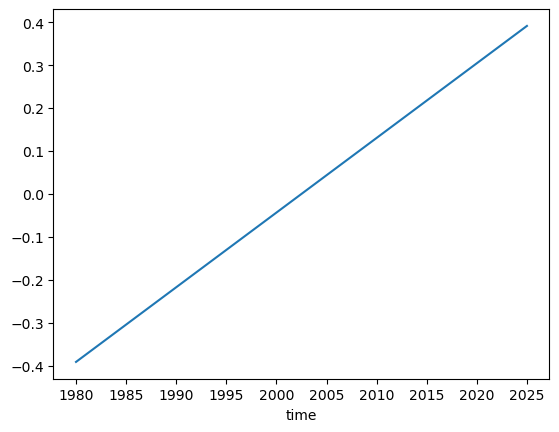

In [12]:
fit_era.mean(['latitude','longitude']).plot(label='ERA-anom fit')

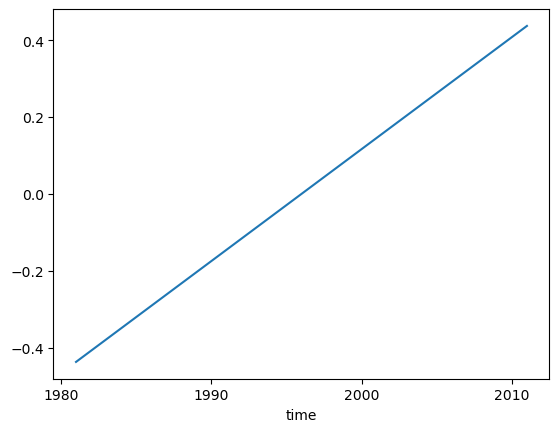

In [15]:
fit_spear_lo[0].mean(['yT','xT']).plot(label='SPEAR-LO ens01-anom fit')

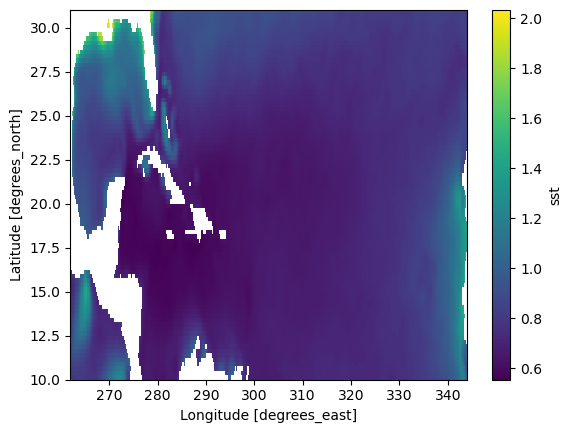

In [15]:
oisst_anom.std('time').plot()

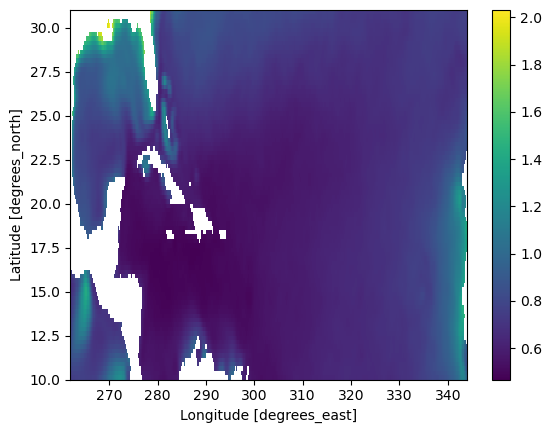

In [14]:
detrended_intime_oisst.std('time').plot()

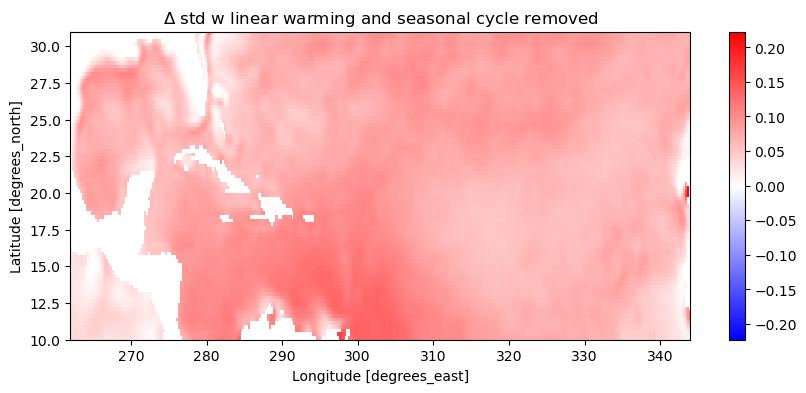

In [16]:
(oisst_anom.std('time') - detrended_intime_oisst.std('time')).plot(figsize=(10,4),
                                                                  cmap='bwr')
plt.title(r'$\Delta$ std w linear warming and seasonal cycle removed');

                 👆👆👆👆👆👆👆👆👆
- Areas with more red means linear compoennt of forced long-term warming trend is more influential
- Areas with pink/whites means interannual variability dominates (ENSO, WBCs, upwelling zones)

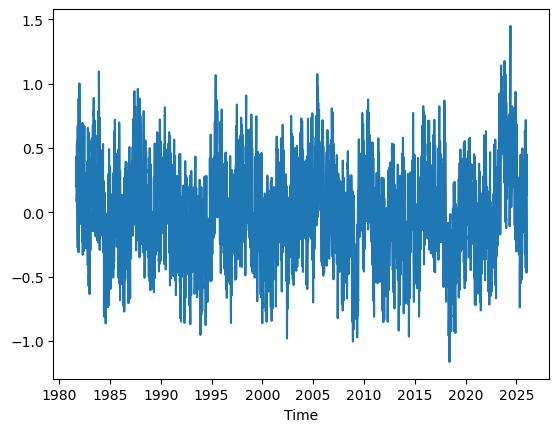

In [17]:
detrended_intime_oisst.mean(['lat', 'lon']).plot(label='detrended')
#fit.mean(['lat','lon']).plot(label='fit')

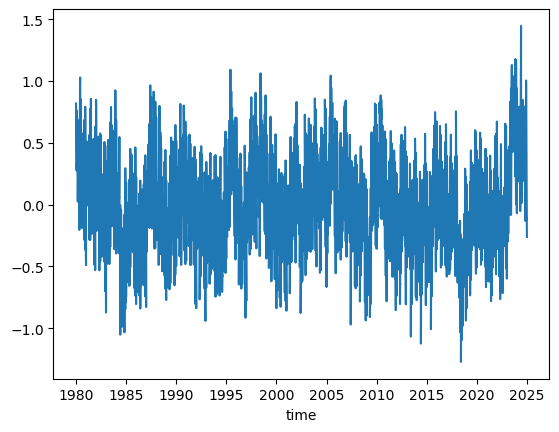

In [18]:
detrended_intime_era.mean(['latitude', 'longitude']).plot(label='detrended-anom')
#fit.mean(['lat','lon']).plot(label='fit')

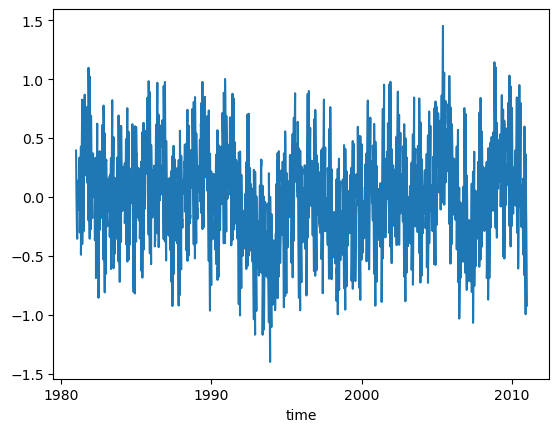

In [16]:
detrended_intime_spear_lo[0].mean(['yT','xT']).plot(label='detrended-anom')
#fit.mean(['lat','lon']).plot(label='fit')

In [18]:
detrended_intime_oisst

<xarray.DataArray (time: 10714, lat: 84, lon: 328)> Size: 2GB
dask.array<sub, shape=(10714, 84, 328), dtype=float64, chunksize=(1, 84, 328), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 1kB 262.1 262.4 262.6 262.9 ... 343.4 343.6 343.9
  * lat      (lat) float32 336B 10.12 10.38 10.62 10.88 ... 30.38 30.62 30.88
  * time     (time) object 86kB 1981-09-01 12:00:00 ... 2010-12-31 12:00:00

In [17]:
detrended_intime_era

<xarray.DataArray (time: 10714, latitude: 85, longitude: 353)> Size: 3GB
dask.array<sub, shape=(10714, 85, 353), dtype=float64, chunksize=(10714, 85, 353), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 1kB 262.0 262.2 262.5 ... 349.5 349.8 350.0
  * latitude   (latitude) float32 340B 31.0 30.75 30.5 30.25 ... 10.5 10.25 10.0
  * time       (time) object 86kB 1981-09-01 12:00:00 ... 2010-12-31 12:00:00

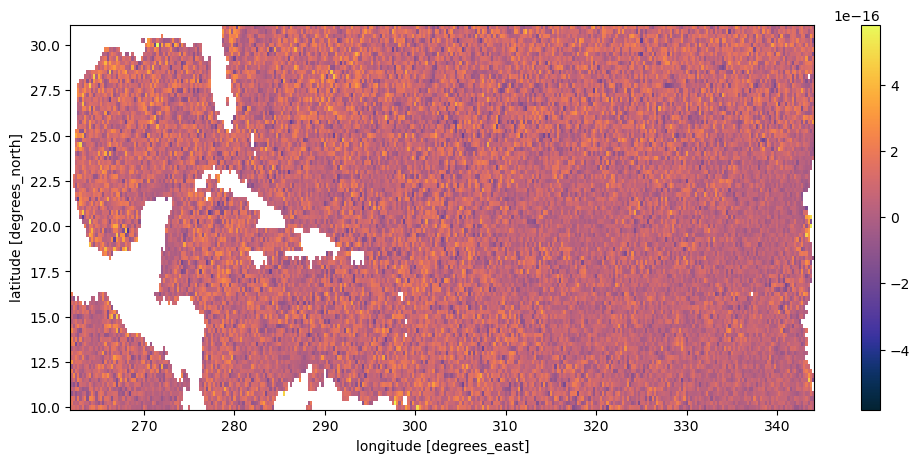

In [19]:
detrended_intime_era.mean('time').plot(figsize=(12,5), cmap=cmocean.cm.thermal)
#fit.mean(['lat','lon']).plot(label='fit')

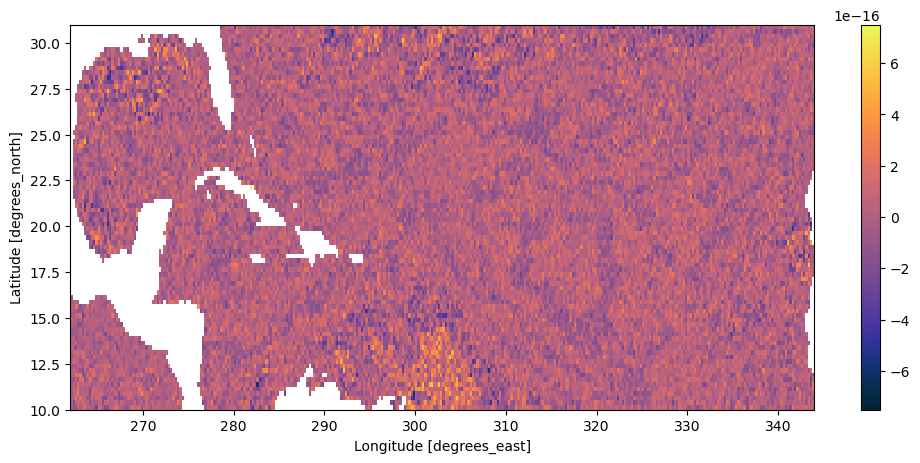

In [20]:
detrended_intime_oisst.mean('time').plot(figsize=(12,5), cmap=cmocean.cm.thermal)

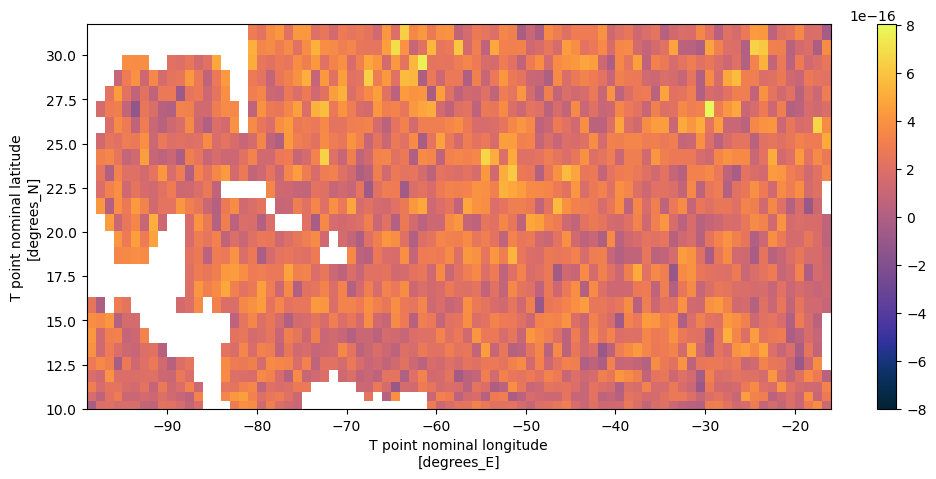

In [17]:
detrended_intime_spear_lo[0].mean('time').plot(figsize=(12,5), cmap=cmocean.cm.thermal)

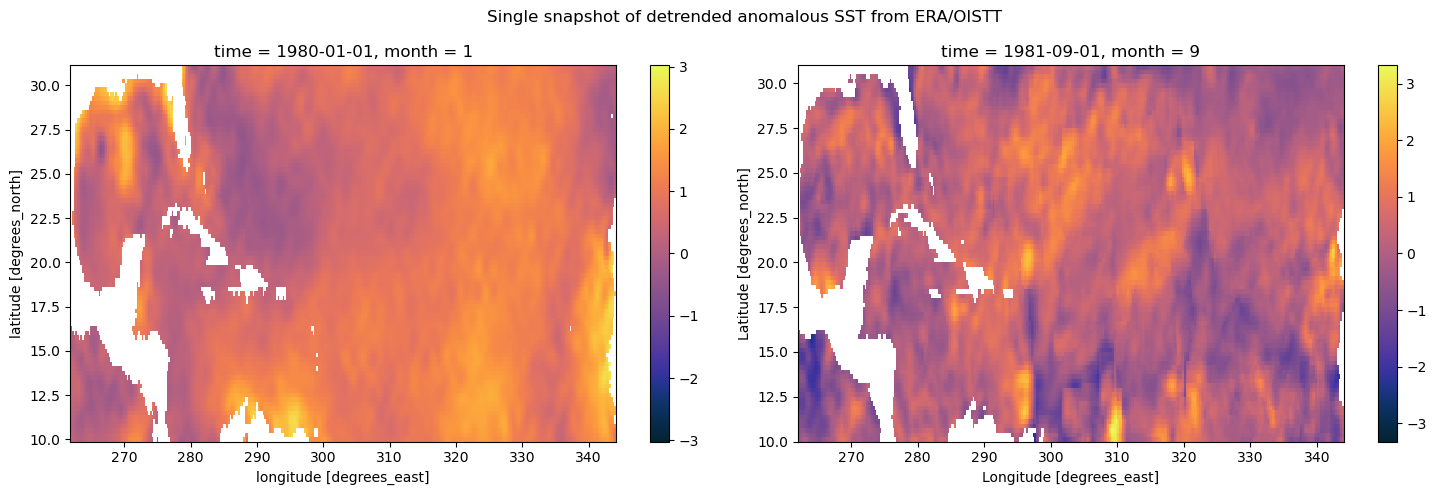

In [22]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
detrended_intime_era[0].plot(cmap=cmocean.cm.thermal, ax=ax0)
detrended_intime_oisst[0].plot(cmap=cmocean.cm.thermal, ax=ax1)
plt.suptitle('Single snapshot of detrended anomalous SST from ERA/OISTT')
plt.tight_layout();

In [23]:
detrended_intime_oisst.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/detrended_intime_oisst_anom.nc')

In [24]:
detrended_intime_era.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/detrended_intime_era_anom.nc')

In [109]:
detrended_intime_spear_lo[0]

<xarray.DataArray (time: 10957, yT: 26, xT: 83)> Size: 189MB
dask.array<sub, shape=(10957, 26, 83), dtype=float64, chunksize=(3653, 26, 83), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 88kB 1981-01-01 12:00:00 ... 2010-12-31 12:00:00
  * xT       (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
  * yT       (yT) float64 208B 10.2 10.67 11.22 11.85 ... 29.59 30.46 31.31

In [18]:
formatted_list = [str(i).zfill(2) for i in range(1, 31)]
for (da,i) in zip(detrended_intime_spear_lo,formatted_list):
    da.to_netcdf(f'/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/detrended/detrended_anom_intime_spear_lo{i}.nc')

In [56]:
detrended_intime_oisstt = detrended_intime_oisst.sel(time=slice('1981', '2010')).assign_coords({'time':
                            detrended_intime_spear_lo[0].time.sel(time=slice('1981-09-01', None))})

In [26]:
detrended_intime_oisst.load()

<xarray.DataArray (time: 16206, lat: 84, lon: 328)> Size: 4GB
array([[[-0.38606355, -0.41649572, -0.20521845, ..., -0.87842107,
         -0.36326544,  0.0505061 ],
        [-0.47425254, -0.49224891, -0.42458126, ..., -1.04615108,
         -0.5928356 , -0.12961527],
        [-0.65647744, -0.62113325, -0.5879582 , ..., -1.00487871,
         -0.46756031, -0.01303338],
        ...,
        [        nan,         nan,         nan, ..., -0.35100021,
         -0.31593882, -0.22684226],
        [        nan,         nan,         nan, ..., -0.39609313,
         -0.25890677, -0.08587184],
        [        nan,         nan,         nan, ..., -0.30865458,
         -0.18774352,  0.03793143]],

       [[-0.75610939, -0.8565437 , -0.66526499, ..., -0.80846135,
         -0.45330369, -0.08953345],
        [-0.95429906, -1.05229777, -0.92462892, ..., -1.05618783,
         -0.66287228, -0.13965462],
        [-1.09652532, -1.12118086, -1.03800488, ..., -1.07491395,
         -0.66760187, -0.11308082],
...
        [        nan,         nan,         nan, ..., -0.03282456,
          0.12472611,  0.25002485],
        [        nan,         nan,         nan, ...,  0.02387733,
          0.20660092,  0.30724706],
        [        nan,         nan,         nan, ...,  0.09962305,
          0.26531038,  0.37076651]],

       [[-0.15105481, -0.08726741, -0.04413432, ...,  0.01872749,
         -0.01860834, -0.09104815],
        [-0.28590921, -0.27832338, -0.25102697, ..., -0.19951727,
         -0.25951571, -0.30161566],
        [-0.51266321, -0.55636174, -0.58454323, ..., -0.39615578,
         -0.41222462, -0.46411363],
        ...,
        [        nan,         nan,         nan, ..., -0.00289397,
          0.16465665,  0.26995342],
        [        nan,         nan,         nan, ...,  0.06380666,
          0.23653172,  0.35717684],
        [        nan,         nan,         nan, ...,  0.15955319,
          0.30524166,  0.41069606]]])
Coordinates:
  * time     (time) datetime64[ns] 130kB 1981-09-01 1981-09-02 ... 2026-01-13
  * lon      (lon) float32 1kB 262.1 262.4 262.6 262.9 ... 343.4 343.6 343.9
  * lat      (lat) float32 336B 10.12 10.38 10.62 10.88 ... 30.38 30.62 30.88
    month    (time) int64 130kB 9 9 9 9 9 9 9 9 9 9 9 ... 1 1 1 1 1 1 1 1 1 1 1

In [27]:
detrended_intime_era.load()

<xarray.DataArray (time: 16437, latitude: 85, longitude: 329)> Size: 4GB
array([[[            nan,             nan,             nan, ...,
          1.46891550e-01,  1.39046964e-01,  1.30848640e-01],
        [            nan,             nan,             nan, ...,
          8.64510703e-02,  8.90244846e-02,  1.08431595e-01],
        [            nan,             nan,             nan, ...,
          2.73946333e-03,  1.58420589e-02,  3.97868692e-02],
        ...,
        [ 2.25161060e-01,  1.68819241e-01,  9.32230782e-02, ...,
          1.34557706e+00,  1.17452769e+00,  1.10765596e+00],
        [ 2.52556147e-01,  2.17417693e-01,  1.53991467e-01, ...,
          1.35861923e+00,  1.14107821e+00,  1.01048253e+00],
        [ 2.57331701e-01,  2.43846903e-01,  1.98088968e-01, ...,
          1.42570790e+00,  1.22479584e+00,  1.06424204e+00]],

       [[            nan,             nan,             nan, ...,
         -2.64812190e-02, -4.98449933e-02, -6.70968419e-02],
        [            nan,             nan,             nan, ...,
         -7.78676336e-02, -9.14597103e-02, -8.43392631e-02],
        [            nan,             nan,             nan, ...,
         -1.53819090e-01, -1.53001194e-01, -1.37462361e-01],
...
        [-5.79685719e-01, -7.47634653e-01, -6.81010867e-01, ...,
         -2.04973739e-01,  1.82244264e-01,  3.19954409e-01],
        [-6.21598859e-01, -5.37968934e-01, -4.12706718e-01, ...,
         -1.47823939e-01, -5.50221813e-04,  2.18514965e-01],
        [-2.62527641e-01, -2.03651039e-01, -1.20780615e-01, ...,
          2.52522326e-01,  1.05358822e-01, -1.60384808e-02]],

       [[            nan,             nan,             nan, ...,
         -9.82004322e-01, -7.80987599e-01, -5.38611397e-01],
        [            nan,             nan,             nan, ...,
         -5.55172720e-01, -3.59867232e-01, -1.83661450e-01],
        [            nan,             nan,             nan, ...,
         -1.73727694e-01, -5.76917447e-02,  2.95000774e-02],
        ...,
        [-5.81034603e-01, -7.21635377e-01, -6.60223242e-01, ...,
         -4.69390822e-01, -1.76598225e-01, -5.90800618e-02],
        [-6.15132484e-01, -5.36715048e-01, -4.18618176e-01, ...,
         -4.03772692e-01, -3.37251878e-01, -2.50659918e-02],
        [-3.00342070e-01, -2.46026230e-01, -1.65111171e-01, ...,
         -5.37622121e-03, -5.48610332e-02, -1.42398027e-01]]])
Coordinates:
  * longitude  (longitude) float32 1kB 262.0 262.2 262.5 ... 343.5 343.8 344.0
  * latitude   (latitude) float32 340B 31.0 30.75 30.5 30.25 ... 10.5 10.25 10.0
  * time       (time) datetime64[ns] 131kB 1980-01-01 1980-01-02 ... 2024-12-31
    month      (time) int64 131kB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12

In [19]:
detrended_intime_spear_lot = []
for i in detrended_intime_spear_lo:
    detrended_intime_spear_lot.append(i.sel(time=slice('1981-09-01', None)))

In [20]:
[i.load() for i in detrended_intime_spear_lot]

[<xarray.DataArray (time: 10714, yT: 26, xT: 83)> Size: 185MB
 array([[[ 5.07742599e-01,  2.13838928e-01,  3.18462302e-01, ...,
           6.04340746e-01,  5.69840840e-01,  5.82544281e-01],
         [ 4.91438556e-01,  1.73486052e-01,  2.93757257e-01, ...,
           6.82799268e-01,  8.30726247e-01,  4.03759783e-01],
         [ 3.41914729e-01,  6.37872805e-02,  1.86955272e-01, ...,
           7.36152579e-01,  1.02972576e+00,  1.42936859e+00],
         ...,
         [            nan,             nan,             nan, ...,
           4.61471745e-03,  4.14318071e-02,  1.17088867e-01],
         [            nan,             nan,             nan, ...,
           1.53050833e-01,  1.02218481e-01,  1.20131350e-01],
         [            nan,             nan,             nan, ...,
           3.16788776e-01,  2.20082964e-01,  1.82048788e-01]],
 
        [[ 7.06428818e-01,  4.20093678e-01,  5.18905741e-01, ...,
           6.60749332e-01,  6.67816264e-01,  5.79129518e-01],
         [ 6.63120304e-01

In [21]:
detrended_intime_spear_lot[0]

<xarray.DataArray (time: 10714, yT: 26, xT: 83)> Size: 185MB
array([[[ 5.07742599e-01,  2.13838928e-01,  3.18462302e-01, ...,
          6.04340746e-01,  5.69840840e-01,  5.82544281e-01],
        [ 4.91438556e-01,  1.73486052e-01,  2.93757257e-01, ...,
          6.82799268e-01,  8.30726247e-01,  4.03759783e-01],
        [ 3.41914729e-01,  6.37872805e-02,  1.86955272e-01, ...,
          7.36152579e-01,  1.02972576e+00,  1.42936859e+00],
        ...,
        [            nan,             nan,             nan, ...,
          4.61471745e-03,  4.14318071e-02,  1.17088867e-01],
        [            nan,             nan,             nan, ...,
          1.53050833e-01,  1.02218481e-01,  1.20131350e-01],
        [            nan,             nan,             nan, ...,
          3.16788776e-01,  2.20082964e-01,  1.82048788e-01]],

       [[ 7.06428818e-01,  4.20093678e-01,  5.18905741e-01, ...,
          6.60749332e-01,  6.67816264e-01,  5.79129518e-01],
        [ 6.63120304e-01,  3.62512390e-01,  4.83626398e-01, ...,
          7.64240036e-01,  9.17420692e-01,  3.76506254e-01],
        [ 4.88866811e-01,  2.43141554e-01,  4.13700718e-01, ...,
          8.40107590e-01,  1.09961300e+00,  1.48687130e+00],
...
        [            nan,             nan,             nan, ...,
         -6.43206671e-01, -8.82959041e-01, -1.09048559e+00],
        [            nan,             nan,             nan, ...,
         -6.69251547e-01, -7.07823167e-01, -8.86256835e-01],
        [            nan,             nan,             nan, ...,
         -4.80771035e-01, -6.84121632e-01, -7.65722062e-01]],

       [[-5.35439973e-01, -7.71950503e-01, -9.59598533e-01, ...,
         -2.75896352e-01,  8.51644828e-01,  1.62039118e+00],
        [-1.16303501e+00, -9.42428043e-01, -1.82294115e+00, ...,
         -3.74704046e-01,  8.09985385e-01,  1.41252807e+00],
        [-8.45701198e-01, -9.70692046e-01, -1.69115874e+00, ...,
         -3.97973587e-01,  3.01863846e-01, -2.25133980e-01],
        ...,
        [            nan,             nan,             nan, ...,
         -7.18949908e-01, -1.02299772e+00, -1.13138202e+00],
        [            nan,             nan,             nan, ...,
         -7.13656156e-01, -8.94051347e-01, -9.25251883e-01],
        [            nan,             nan,             nan, ...,
         -5.10703455e-01, -7.24922716e-01, -8.35363163e-01]]])
Coordinates:
  * time     (time) object 86kB 1981-09-01 12:00:00 ... 2010-12-31 12:00:00
  * xT       (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
  * yT       (yT) float64 208B 10.2 10.67 11.22 11.85 ... 29.59 30.46 31.31
    month    (time) int64 86kB 9 9 9 9 9 9 9 9 9 ... 12 12 12 12 12 12 12 12 12

## 90$^{th}$ Percentile, Duration count

In [22]:
def compute_daily_percentile_exceedance(da, time_dim='time', spatial_dims=('lat', 'lon'), #('xh', 'yh') 
                                        percentile=0.9):
    """
    Compute daily climatological percentile exceedance.

    Parameters
    ----------
    da : xr.DataArray
        Input data (e.g. detrended SST)
    time_dim : str
        Name of time dimension
    spatial_dims : tuple of str
        Spatial dimensions (e.g. ('lat','lon'))
    percentile : float
        Percentile threshold (e.g. 0.9)

    Returns
    -------
    exceedance_masked : xr.DataArray
    exceedance_bool : xr.DataArray (bool)
    exceedance_int  : xr.DataArray (int)
    threshold       : xr.DataArray
    """

    # Group by day of the year and then calculate the 90th percentile for each day
    grouped = da.groupby(f'{time_dim}.dayofyear')

    # Percentile climatology
    clim_p = grouped.quantile(percentile, dim=time_dim)

    # Align climatology with full time series
    #AKA reindex and repeat the clim_p array to match the full dataset's dayofyear
    dayofyear = da[time_dim].dt.dayofyear
    threshold = clim_p.sel(dayofyear=dayofyear)

    # Exceedance masks:
    #Identify temp/days where current temperature exceeds the 90th percentile baseline
    exceedance_masked = da.where(da > threshold)
    #Make boolean mask of days that exceed 90th percentile
    exceedance_bool = da > threshold
    #Make boolean mask to int to count days for 5-day dur/3-day gap threshold
    exceedance_int = exceedance_bool.astype(int)

    return exceedance_masked, exceedance_bool, exceedance_int, threshold

In [23]:
#First func is used in 2nd func
def find_events(arr, min_run=5, min_sep=3):
    events = []
    current_run_start = None

    for i, val in enumerate(arr):
        if val == 1:
            if current_run_start is None:
                current_run_start = i
        else:
            if current_run_start is not None:
                run_length = i - current_run_start

                if run_length >= min_run:
                    if events:
                        prev_start, prev_end = events[-1]
                        if current_run_start - prev_end >= min_sep:
                            events.append((current_run_start, i - 1))
                        else:
                            events[-1] = (prev_start, i - 1)
                    else:
                        events.append((current_run_start, i - 1))

                current_run_start = None

    # Handle run ending at final timestep
    if current_run_start is not None:
        run_length = len(arr) - current_run_start
        if run_length >= min_run:
            if events:
                prev_start, prev_end = events[-1]
                if current_run_start - prev_end >= min_sep:
                    events.append((current_run_start, len(arr) - 1))
                else:
                    events[-1] = (prev_start, len(arr) - 1)
            else:
                events.append((current_run_start, len(arr) - 1))

    return events

def detect_events_xarray(exceedance_int, time_dim="time", spatial_dims=("lat", "lon"), 
                         min_run=5, min_sep=3):
    """
    Apply event detection to each grid cell of an exceedance array.

    Parameters
    ----------
    exceedance_int : xr.DataArray
        Integer exceedance mask (0/1)
    time_dim : str
        Time dimension name
    spatial_dims : tuple of str
        Spatial dimensions
    min_run : int
        Minimum duration (days)
    min_sep : int
        Minimum separation (days)

    Returns
    -------
    events_by_cell : dict
        {(coord_tuple): [(start_idx, end_idx), ...]}
    event_mask : xr.DataArray (bool)
    """

    # Stack spatial dimensions
    stacked = exceedance_int.stack(grid_cell=spatial_dims)

    events_by_cell = {}

    for cell in stacked.grid_cell.values:
        ts = stacked.sel(grid_cell=cell).values
        events = find_events(ts, min_run=min_run, min_sep=min_sep)

        if events:
            events_by_cell[cell] = events

    # Build boolean mask
    event_mask = xr.zeros_like(exceedance_int, dtype=bool)
    time_vals = exceedance_int[time_dim]

    for cell, events in events_by_cell.items():
        cell_dict = dict(zip(spatial_dims, cell))

        for start, end in events:
            event_mask.loc[
                {
                    **cell_dict,
                    time_dim: time_vals[start:end+1]
                }
            ] = True

    return events_by_cell, event_mask

In [47]:
detrended_intime_era.sel(time=slice('1981-09', '2010'))

<xarray.DataArray (time: 10714, latitude: 85, longitude: 329)> Size: 2GB
array([[[        nan,         nan,         nan, ..., -0.3928566 ,
         -0.41697047, -0.47561172],
        [        nan,         nan,         nan, ..., -0.37566268,
         -0.394325  , -0.45989341],
        [        nan,         nan,         nan, ..., -0.38611634,
         -0.38730194, -0.44042332],
        ...,
        [-0.69970163, -0.70349746, -0.70570576, ..., -0.26563253,
         -0.27494081, -0.22336649],
        [-0.52298769, -0.55832797, -0.57325171, ..., -0.27828401,
         -0.21918695, -0.16164415],
        [-0.44118003, -0.49575825, -0.51606952, ..., -0.36234666,
         -0.28975621, -0.22984638]],

       [[        nan,         nan,         nan, ..., -0.39610108,
         -0.42212354, -0.4903139 ],
        [        nan,         nan,         nan, ..., -0.38272633,
         -0.40457009, -0.47968733],
        [        nan,         nan,         nan, ..., -0.40081937,
         -0.40709557, -0.47040179],
...
        [-1.54176993, -1.53490818, -1.45899995, ...,  0.85836673,
          0.85645754,  0.82001152],
        [-1.24172901, -1.22339446, -1.14797864, ...,  0.93785309,
          0.87254173,  0.80554605],
        [-1.06800695, -1.1002085 , -1.0609574 , ...,  0.92912022,
          0.83554637,  0.77344331]],

       [[        nan,         nan,         nan, ..., -0.67492328,
         -0.54095572, -0.40919626],
        [        nan,         nan,         nan, ..., -0.64604239,
         -0.48260518, -0.30072452],
        [        nan,         nan,         nan, ..., -0.58193603,
         -0.41717897, -0.22636583],
        ...,
        [-1.50189211, -1.50466994, -1.45629766, ...,  0.98912757,
          0.96519132,  0.91359715],
        [-1.27688058, -1.27782262, -1.23200786, ...,  1.05897963,
          0.98402858,  0.9005101 ],
        [-1.16373177, -1.2138327 , -1.19867557, ...,  1.01720981,
          0.91330782,  0.83330503]]])
Coordinates:
  * longitude  (longitude) float32 1kB 262.0 262.2 262.5 ... 343.5 343.8 344.0
  * latitude   (latitude) float32 340B 31.0 30.75 30.5 30.25 ... 10.5 10.25 10.0
  * time       (time) datetime64[ns] 86kB 1981-09-01 1981-09-02 ... 2010-12-31
    month      (time) int64 86kB 9 9 9 9 9 9 9 9 9 ... 12 12 12 12 12 12 12 12

In [46]:
%%time
# Step 1: exceedance
ex_masked_oi, ex_bool_oi, ex_int_oi, threshold_oi = compute_daily_percentile_exceedance(detrended_intime_oisst.sel(time=slice(None, '2010')), 
                                                                                        time_dim='time',
                                                                                        spatial_dims=('lat', 'lon'),
                                                                                        percentile=0.9)

CPU times: user 28 s, sys: 8.17 s, total: 36.1 s
Wall time: 36.2 s


In [48]:
%%time
# Step 1: exceedance
ex_masked_era, ex_bool_era, ex_int_era, threshold_era = compute_daily_percentile_exceedance(detrended_intime_era.sel(time=slice('1981-09', '2010')), 
                                                                                        time_dim='time',
                                                                                        spatial_dims=('latitude', 
                                                                                                      'longitude'),
                                                                                        percentile=0.9)

CPU times: user 29.4 s, sys: 7.91 s, total: 37.3 s
Wall time: 37.4 s


In [24]:
%%time
# Step 1: exceedance
ex_masked_splo = [] 
ex_bool_splo = [] 
ex_int_splo = [] 
threshold_splo = []
for da in tqdm(detrended_intime_spear_lot):
    ex_masked_sl, ex_bool_sl, ex_int_sl, threshold_sl = compute_daily_percentile_exceedance(da, time_dim='time',
                                                                                        spatial_dims=('yT', 'xT'),
                                                                                            percentile=0.9)
    ex_masked_splo.append(ex_masked_sl) 
    ex_bool_splo.append(ex_bool_sl) 
    ex_int_splo.append(ex_int_sl) 
    threshold_splo.append(threshold_sl)

100%|██████████| 30/30 [01:11<00:00,  2.38s/it]

CPU times: user 55.2 s, sys: 15.9 s, total: 1min 11s
Wall time: 1min 11s


In [49]:
ex_masked_era.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/ex_masked_era.nc', mode='w')

In [50]:
ex_bool_era.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/ex_bool_era.nc', mode='w')

In [51]:
ex_int_era.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/ex_int_era.nc', mode='w')

In [52]:
threshold_era.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/treshold_era.nc', mode='w')

In [53]:
ex_masked_oi.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/ex_masked_oi.nc', mode='w')

In [54]:
ex_bool_oi.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/ex_bool_oi.nc', mode='w')

In [55]:
ex_int_oi.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/ex_int_oi.nc', mode='w')

In [56]:
threshold_oi.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/treshold_oi.nc', mode='w')

In [26]:
formatted_list = [str(i).zfill(2) for i in range(1, 31)]
for (da,i) in zip(ex_masked_splo,formatted_list):
    da.to_netcdf(f'/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/exceedance/ex_masked_splo{i}.nc', mode='w')

In [27]:
formatted_list = [str(i).zfill(2) for i in range(1, 31)]
for (da,i) in zip(ex_bool_splo,formatted_list):
    da.to_netcdf(f'/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/exceedance/ex_bool_splo{i}.nc', mode='w')

In [28]:
formatted_list = [str(i).zfill(2) for i in range(1, 31)]
for (da,i) in zip(ex_int_splo,formatted_list):
    da.to_netcdf(f'/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/exceedance/ex_int_splo{i}.nc', mode='w')

In [29]:
formatted_list = [str(i).zfill(2) for i in range(1, 31)]
for (da,i) in zip(threshold_splo,formatted_list):
    da.to_netcdf(f'/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/exceedance/threshold_splo{i}.nc', mode='w')

In [58]:
%%time
# Step 2: event detection
events_by_cell_oi, event_mask_oi = detect_events_xarray(ex_int_oi, time_dim='time', spatial_dims=('lat', 'lon'), 
                                                          min_run=5, min_sep=3)

CPU times: user 33min 38s, sys: 1.9 s, total: 33min 40s
Wall time: 33min 47s


In [59]:
%%time
# Step 2: event detection
events_by_cell_era, event_mask_era = detect_events_xarray(ex_int_era, time_dim='time', 
                                                          spatial_dims=('latitude', 'longitude'), 
                                                          min_run=5, min_sep=3)

CPU times: user 39min 35s, sys: 1.24 s, total: 39min 36s
Wall time: 39min 44s


In [60]:
event_mask_oi.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/event_mask_oi.nc')

In [61]:
event_mask_era.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/event_mask_era.nc')

In [62]:
# Convert tuple keys to strings
stringified_dict = {str(k): v for k, v in events_by_cell_oi.items()}

# Now you can save the dictionary to a JSON file
with open("/work5/stb/MHW-gfdl/SPEAR/vars/OISST/events_by_cell_oi.json", "w") as f:
    json.dump(stringified_dict, f, indent=4)


In [63]:
# Convert tuple keys to strings
stringified_dict = {str(k): v for k, v in events_by_cell_era.items()}

# Now you can save the dictionary to a JSON file
with open("/work5/stb/MHW-gfdl/SPEAR/vars/ERA5/events_by_cell_era.json", "w") as f:
    json.dump(stringified_dict, f, indent=4)

In [30]:
%%time
# Step 2: event detection
events_by_cell_splo = [] 
event_mask_splo = [] 

for da in tqdm(ex_int_splo):
    events_by_cell_sl, event_mask_sl = detect_events_xarray(da, time_dim='time', 
                                                            spatial_dims=('yT', 'xT'), min_run=5, min_sep=3)
    events_by_cell_splo.append(events_by_cell_sl)
    event_mask_splo.append(event_mask_sl)

100%|██████████| 30/30 [1:06:21<00:00, 132.73s/it]

CPU times: user 1h 6min 5s, sys: 2 s, total: 1h 6min 7s
Wall time: 1h 6min 21s


In [31]:
formatted_list = [str(i).zfill(2) for i in range(1, 31)]
for (da,i) in zip(event_mask_splo,formatted_list):
    da.to_netcdf(f'/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/events/event_mask_splo{i}.nc')

In [32]:
# 1. Convert tuple keys to strings for every dictionary in the list
stringified_list = [{str(k): v for k, v in d.items()} 
                    for d in events_by_cell_splo]

# 2. Save the processed list to a JSON file
file_path = "/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/events/events_by_cell_splo.json"
with open(file_path, "w") as f:
    json.dump(stringified_list, f, indent=4)


In [138]:
import json

with open('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/events/events_by_cell_splo.json', 'r') as json_file:
    loaded_dict = json.load(json_file)

In [ ]:
events_by_cell_splo == events_by_c

In [141]:
loaded_dict == stringified_list

False

In [82]:
events_by_cell_oi

{(10.125, 262.125): [(24, 28),
  (169, 173),
  (204, 214),
  (225, 229),
  (246, 251),
  (261, 267),
  (348, 354),
  (460, 464),
  (481, 485),
  (505, 509),
  (553, 557),
  (622, 627),
  (630, 634),
  (655, 659),
  (677, 694),
  (713, 726),
  (1150, 1154),
  (1158, 1162),
  (1504, 1508),
  (2030, 2035),
  (2119, 2125),
  (2129, 2139),
  (2204, 2214),
  (2273, 2310),
  (2315, 2322),
  (2383, 2388),
  (2430, 2436),
  (2633, 2638),
  (3291, 3299),
  (3554, 3574),
  (3641, 3649),
  (3666, 3672),
  (3867, 3871),
  (4066, 4071),
  (4147, 4151),
  (4181, 4187),
  (4190, 4196),
  (4272, 4277),
  (4296, 4302),
  (4310, 4316),
  (4732, 4736),
  (4818, 4828),
  (5181, 5185),
  (5917, 5921),
  (5928, 5946),
  (5950, 5962),
  (5970, 6029),
  (6042, 6046),
  (6116, 6133),
  (7122, 7129),
  (7268, 7276),
  (7604, 7610),
  (7647, 7652),
  (7709, 7729),
  (8366, 8370),
  (8598, 8602),
  (10178, 10182),
  (10195, 10199),
  (10221, 10243),
  (10253, 10272)],
 (10.125, 262.375): [(24, 28),
  (168, 173),
 

In [91]:
def cartopy_plot(da, cmap_choice, cbar_label, var_title, vmin=None, vmax=None, quiver=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=proj))
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    # ---- infer coord names if not provided ----
    lat_candidates = ['lat', 'latitude', 'yT', 'yh']
    lon_candidates = ['lon', 'longitude', 'xT', 'xh']

    lat_name = next((c for c in lat_candidates if c in da.coords), None)
    lon_name = next((c for c in lon_candidates if c in da.coords), None)

    if lat_name is None or lon_name is None:
        raise ValueError(
            f"Could not infer lat/lon coordinates. "
            f"Found coords: {list(da.coords)}"
        )

    lats = da[lat_name]
    lons = da[lon_name]
    # -------------------------------------------------------------------------------
    
    im = ax.pcolormesh(lons, lats, da, transform=ccrs.PlateCarree(), 
                       vmin=vmin, vmax=vmax, cmap=cmap_choice)
    cb = fig.colorbar(im, ax=ax, shrink=0.4)
    cb.set_label(fr"{cbar_label}", labelpad=8, fontsize=14)
    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    plt.title(f'{var_title}', fontsize=16, y=1.07)

In [96]:
ex_int_oi.time.dtype

dtype('O')

In [97]:
np.issubdtype?

Signature: np.issubdtype(arg1, arg2)
Docstring:
Returns True if first argument is a typecode lower/equal in type hierarchy.

This is like the builtin :func:`issubclass`, but for `dtype`\ s.

Parameters
----------
arg1, arg2 : dtype_like
    `dtype` or object coercible to one

Returns
-------
out : bool

See Also
--------
:ref:`arrays.scalars` : Overview of the numpy type hierarchy.

Examples
--------
`issubdtype` can be used to check the type of arrays:

>>> ints = np.array([1, 2, 3], dtype=np.int32)
>>> np.issubdtype(ints.dtype, np.integer)
True
>>> np.issubdtype(ints.dtype, np.floating)
False

>>> floats = np.array([1, 2, 3], dtype=np.float32)
>>> np.issubdtype(floats.dtype, np.integer)
False
>>> np.issubdtype(floats.dtype, np.floating)
True

Similar types of different sizes are not subdtypes of each other:

>>> np.issubdtype(np.float64, np.float32)
False
>>> np.issubdtype(np.float32, np.float64)
False

but both are subtypes of `floating`:

>>> np.issubdtype(np.float64, np.floating)


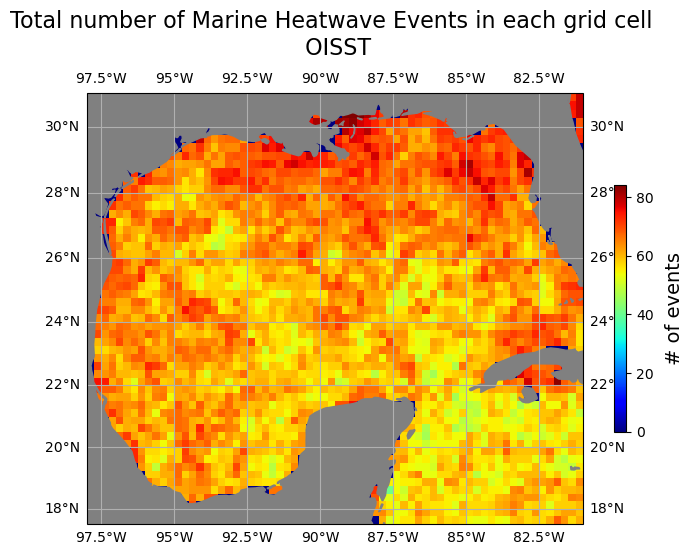

In [99]:
# ---- infer spatial dimensions from the data ----
#time_dim = next(
#    d for d in ex_int_oi.dims
#    if np.issubdtype(ex_int_oi[d].dtype, np.datetime64)
#)
import cftime

time_dim = next(
    d for d in ex_int_oi.dims
    if (
        ex_int_oi[d].dtype.kind == "M"
        or (
            ex_int_oi[d].dtype == object
            and isinstance(ex_int_oi[d].values[0], (np.datetime64, cftime.datetime)))))

spatial_dims = tuple(d for d in ex_int_oi.dims if d != time_dim)

# ---- create empty array with correct spatial metadata ----
event_count_oi = xr.zeros_like(ex_int_oi.isel({time_dim: 0}), dtype=int)

# ---- fill with number of events per grid cell ----
for cell, events in events_by_cell_oi.items():
    cell_dict = dict(zip(spatial_dims, cell))
    event_count_oi.loc[cell_dict] = len(events)

cartopy_plot(event_count_oi, 'jet', '# of events', 
             'Total number of Marine Heatwave Events in each grid cell \n OISST')

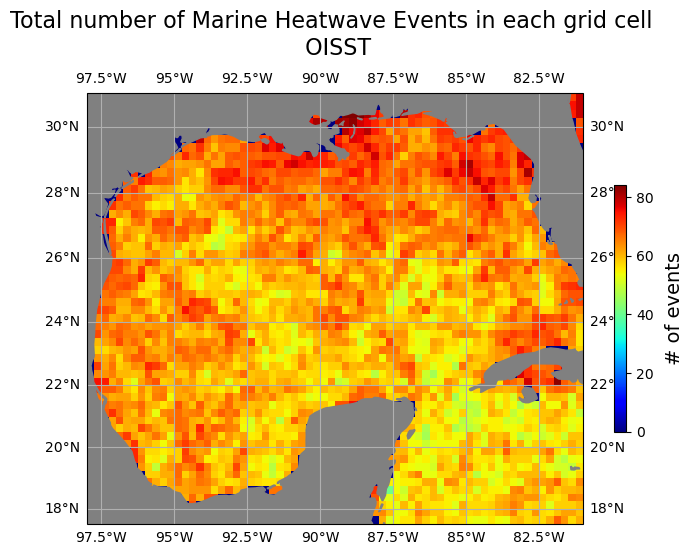

In [101]:
# create empty array to get spatial and meta data
event_count = xr.zeros_like(ex_int_oi.isel(time=0), dtype=int) #{lat:56, lon:79} da of 0s
#for key (lat/lon), events (start/stop indices) in da dictionary:
#empty_da.loc[dict((lat, lon))] = len(all events in that grid cell)
for (lat, lon), events in events_by_cell_oi.items(): #items are the lat/lon pairs
    event_count.loc[dict(lat=lat, lon=lon)] = len(events)

cartopy_plot(event_count, 'jet', '# of events', 
             'Total number of Marine Heatwave Events in each grid cell \n OISST');

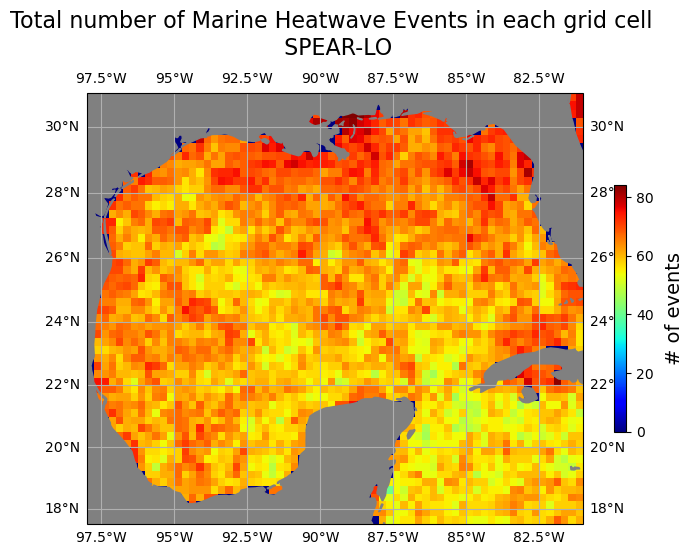

In [100]:
# create empty array to get spatial and meta data
event_count = xr.zeros_like(ex_int_oi.isel(time=0), dtype=int) #{lat:56, lon:79} da of 0s
#for key (lat/lon), events (start/stop indices) in da dictionary:
#empty_da.loc[dict((lat, lon))] = len(all events in that grid cell)
for (lat, lon), events in events_by_cell_oi.items(): #items are the lat/lon pairs
    event_count.loc[dict(lat=lat, lon=lon)] = len(events)

cartopy_plot(event_count, 'jet', '# of events', 
             'Total number of Marine Heatwave Events in each grid cell \n SPEAR-LO');

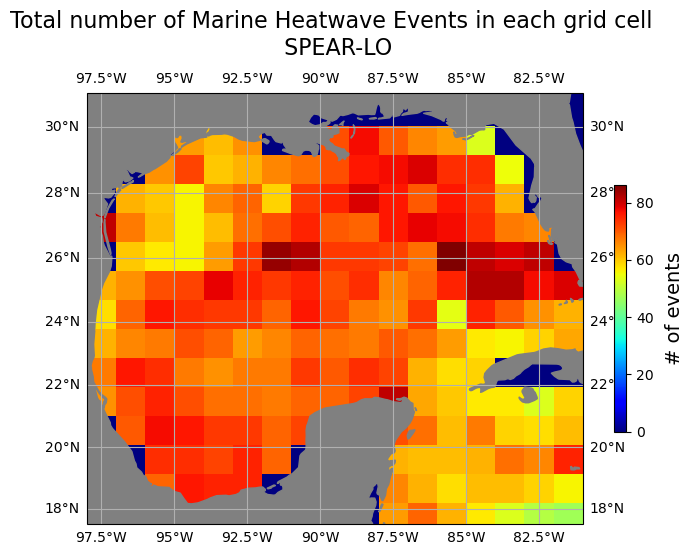

In [103]:
# create empty array to get spatial and meta data
event_count = xr.zeros_like(ex_int_splo[0].isel(time=0), dtype=int) #{lat:56, lon:79} da of 0s
#for key (lat/lon), events (start/stop indices) in da dictionary:
#empty_da.loc[dict((lat, lon))] = len(all events in that grid cell)
for (lat, lon), events in events_by_cell_splo[0].items(): #items are the lat/lon pairs
    event_count.loc[dict(yT=lat, xT=lon)] = len(events)

cartopy_plot(event_count, 'jet', '# of events', 
             'Total number of Marine Heatwave Events in each grid cell \n SPEAR-LO');

In [25]:
event_count.max()

<xarray.DataArray ()> Size: 8B
array(86)
Coordinates:
    time       object 8B 1981-01-01 12:00:00
    quantile   float64 8B 0.9
    dayofyear  int64 8B 1

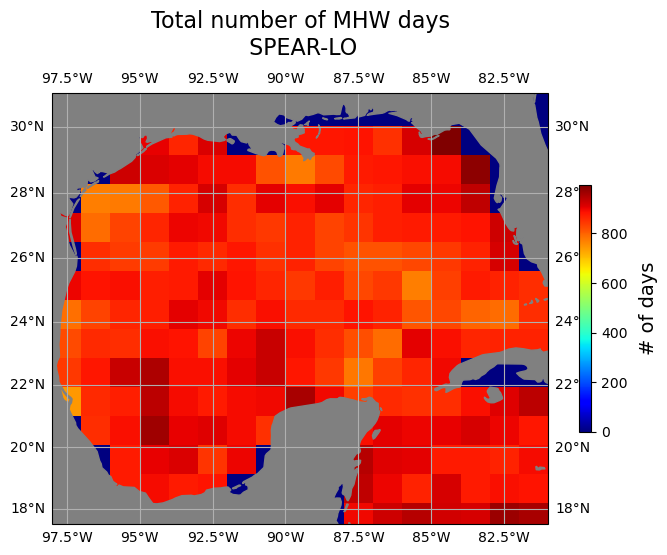

In [26]:
total_mhw_days = event_mask.sum(dim="time")
cartopy_plot(total_mhw_days, 'xT', 'yT', 'jet', '# of days', 
             'Total number of MHW days\n SPEAR-LO');#if time res is daily


In [49]:
event_mask.lat

<xarray.DataArray 'lat' (lat: 56)> Size: 224B
array([17.125, 17.375, 17.625, 17.875, 18.125, 18.375, 18.625, 18.875, 19.125,
       19.375, 19.625, 19.875, 20.125, 20.375, 20.625, 20.875, 21.125, 21.375,
       21.625, 21.875, 22.125, 22.375, 22.625, 22.875, 23.125, 23.375, 23.625,
       23.875, 24.125, 24.375, 24.625, 24.875, 25.125, 25.375, 25.625, 25.875,
       26.125, 26.375, 26.625, 26.875, 27.125, 27.375, 27.625, 27.875, 28.125,
       28.375, 28.625, 28.875, 29.125, 29.375, 29.625, 29.875, 30.125, 30.375,
       30.625, 30.875], dtype=float32)
Coordinates:
  * lat       (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile  float64 8B 0.9
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    axis:           Y
    actual_range:   [17.125 30.875]

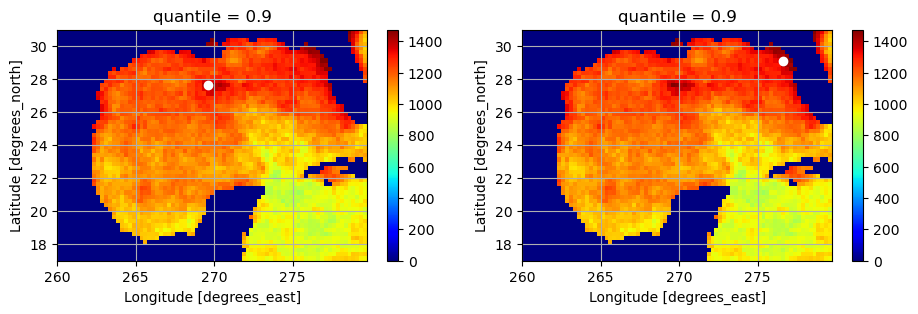

In [53]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11, 3))
total_mhw_days.plot(cmap='jet', ax=ax0)
ax0.grid()
ax0.plot(269.625, 27.625, 'wo')

total_mhw_days.plot(cmap='jet', ax=ax1)
ax1.grid()
ax1.plot(276.625, 29.125, 'wo');

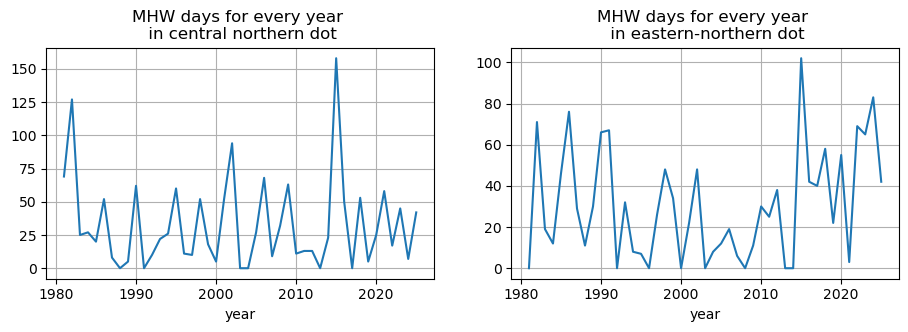

In [55]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11, 3))
event_mask.sel(lat=27.625, lon=269.625).groupby('time.year').sum('time').plot(ax=ax0)
ax0.grid()
ax0.set_title('MHW days for every year \n in central northern dot')
event_mask.sel(lat=29.125, lon=276.625).groupby('time.year').sum('time').plot(ax=ax1)
ax1.grid()
ax1.set_title('MHW days for every year \n in eastern-northern dot');

In [27]:
records = []

for (lat, lon), events in events_by_cell.items():
    for i, (start, end) in enumerate(events):
        records.append({
            "yT": lat,
            "xT": lon,
            "event": i,
            "duration": end - start + 1
        })

In [28]:
records

[{'yT': 17.71856340620927, 'xT': -87.5, 'event': 0, 'duration': 8},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 1, 'duration': 8},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 2, 'duration': 21},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 3, 'duration': 10},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 4, 'duration': 11},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 5, 'duration': 18},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 6, 'duration': 12},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 7, 'duration': 10},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 8, 'duration': 5},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 9, 'duration': 20},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 10, 'duration': 5},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 11, 'duration': 6},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 12, 'duration': 5},
 {'yT': 17.71856340620927, 'xT': -87.5, 'event': 13, 'duration': 13},
 {'yT': 17.71856340620927, 'xT': -87

In [29]:
df = pd.DataFrame(records)

duration_da = (df.set_index(["yT", "xT", "event"]).to_xarray())["duration"]

In [30]:
df

yT    xT  event  duration
0      17.718563 -87.5      0         8
1      17.718563 -87.5      1         8
2      17.718563 -87.5      2        21
3      17.718563 -87.5      3        10
4      17.718563 -87.5      4        11
...          ...   ...    ...       ...
13192  29.589593 -84.5     49        26
13193  29.589593 -84.5     50        52
13194  29.589593 -84.5     51        17
13195  29.589593 -84.5     52        29
13196  29.589593 -84.5     53         6

[13197 rows x 4 columns]

In [31]:
duration_da

<xarray.DataArray 'duration' (yT: 14, xT: 17, event: 86)> Size: 164kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 5.,  6.,  6., ..., nan, nan, nan],
        [13.,  5., 13., ..., nan, nan, nan],
        [11.,  5., 13., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [ 8., 10.,  5., ..., nan, nan, nan],
        ...,
        [ 9., 10., 16., ..., nan, nan, nan],
        [10.,  6., 14., ..., nan, nan, nan],
        [10., 15., 12., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [ 7.,  7.,  5., ..., nan, nan, nan],
        ...,
...
        ...,
        [13., 14.,  9., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [ 6.,  6.,  5., ..., nan, nan, nan],
        ...,
        [23., 16., 13., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * yT       (yT) float64 112B 17.72 18.66 19.61 20.55 ... 27.84 28.72 29.59
  * xT       (xT) float64 136B -97.5 -96.5 -95.5 -94.5 ... -83.5 -82.5 -81.5
  * event    (event) int64 688B 0 1 2 3 4 5 6 7 8 ... 77 78 79 80 81 82 83 84 85

In [32]:
mean_duration = duration_da.mean(dim="event")
median_duration = duration_da.median(dim="event")
max_duration = duration_da.max(dim="event")

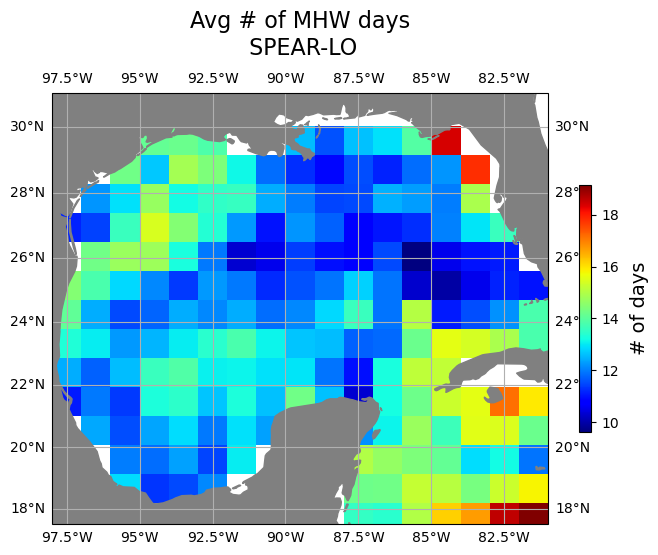

In [33]:
cartopy_plot(mean_duration, 'xT', 'yT', 'jet', '# of days', 
             'Avg # of MHW days\n SPEAR-LO')#,vmin=0, vmax=14,);#if time res is daily


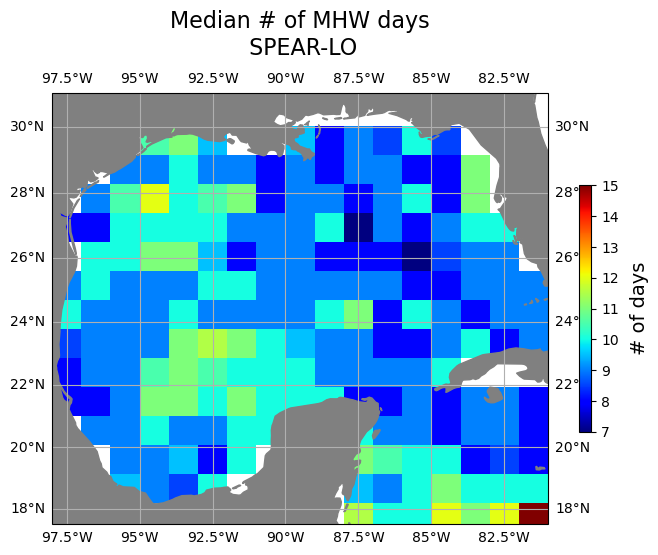

In [34]:
cartopy_plot(median_duration, 'xT', 'yT', 'jet', '# of days', 
             'Median # of MHW days\n SPEAR-LO');#if time res is daily


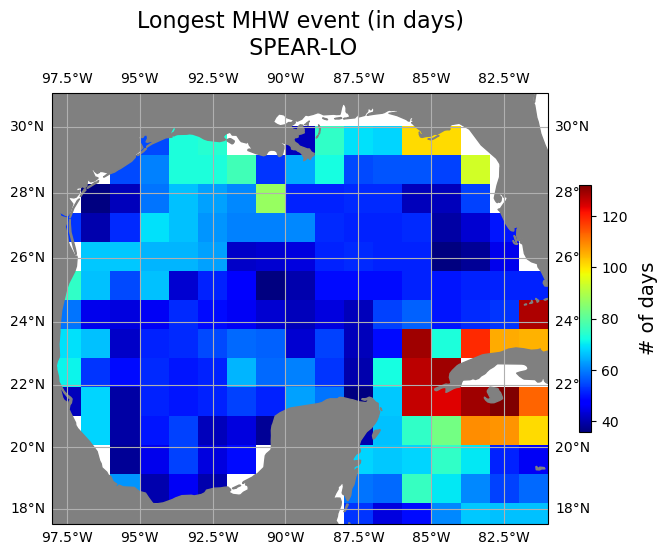

In [35]:
cartopy_plot(max_duration, 'xT', 'yT', 'jet', '# of days', 
             'Longest MHW event (in days)\n SPEAR-LO');#if time res is daily


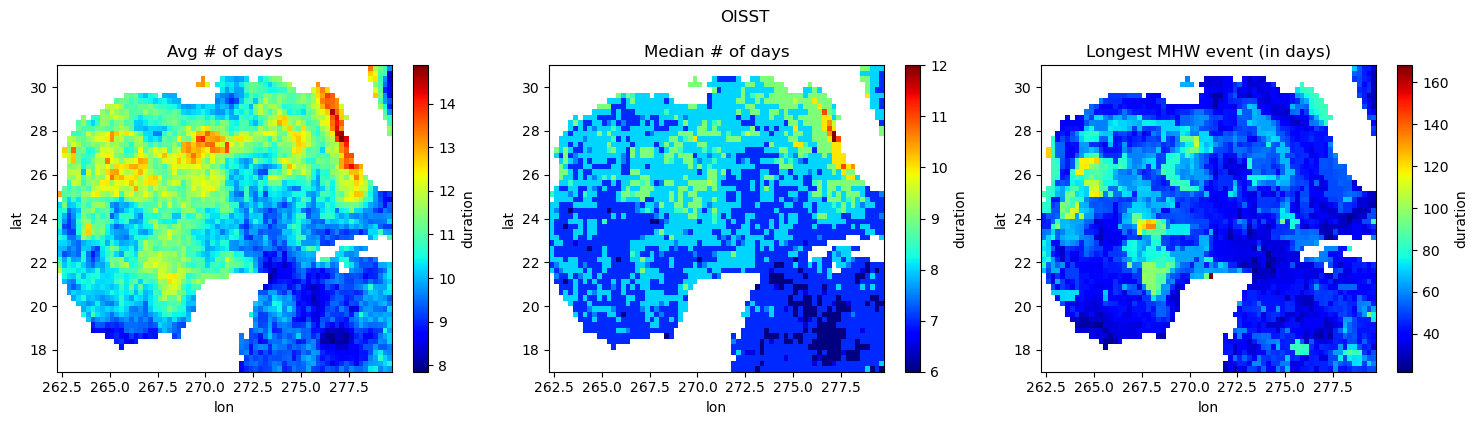

In [43]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
mean_duration.plot(ax=ax[0], cmap='jet')
ax[0].set_title('Avg # of days')
median_duration.plot(ax=ax[1], cmap='jet')
ax[1].set_title('Median # of days')
max_duration.plot(ax=ax[2], cmap='jet')
ax[2].set_title('Longest MHW event (in days)')
plt.tight_layout()
plt.suptitle('OISST', y=1.05);

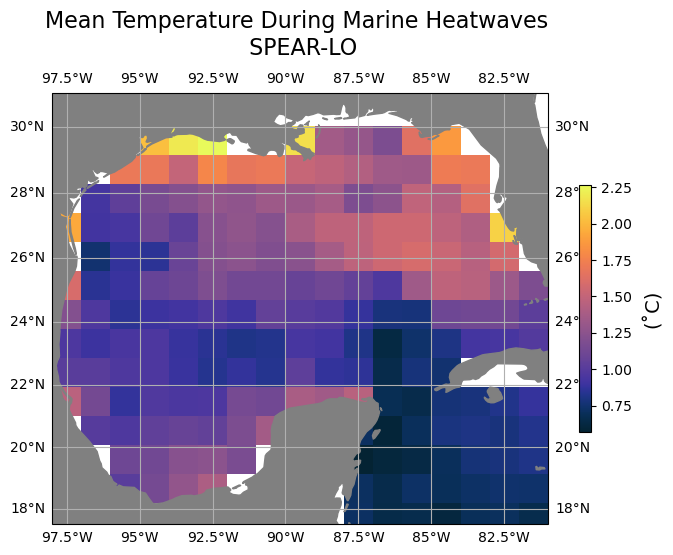

In [36]:
mhw_events = detrended_intime.where(event_mask)
mean_mhw_temp = mhw_events.mean(dim="time")

cartopy_plot(mean_mhw_temp, 'xT', 'yT', cmocean.cm.thermal, '(˚C)', 
             'Mean Temperature During Marine Heatwaves \n SPEAR-LO',);

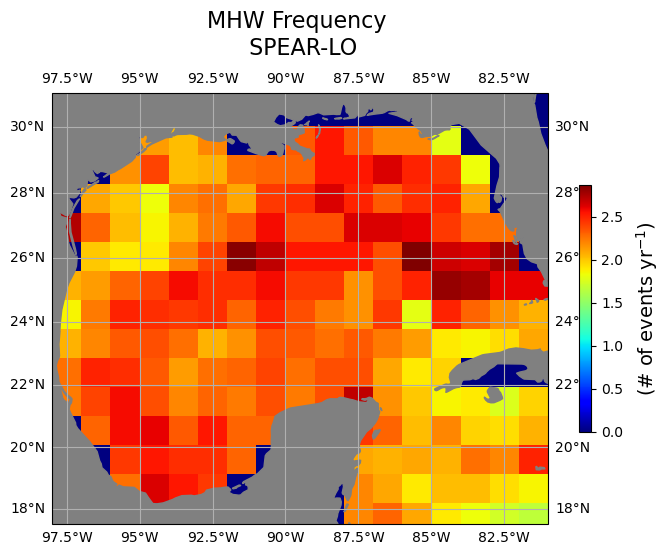

In [37]:
years = detrended_intime.time.dt.year.values
nyears = np.unique(years).size #total time period
event_freq = event_count / nyears

cartopy_plot(event_freq, 'xT', 'yT', 'jet', r'(# of events yr$^{-1}$)', 'MHW Frequency \n SPEAR-LO');

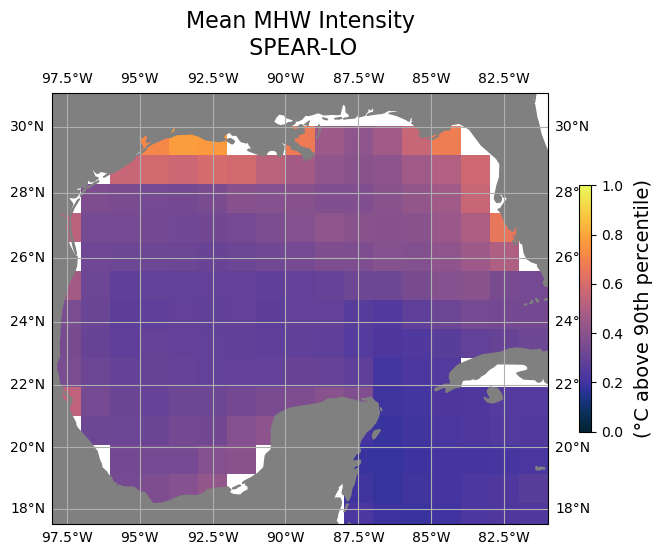

In [38]:
mhw_intensity = (mhw_events - threshold).mean(dim="time")

cartopy_plot(mhw_intensity, 'xT', 'yT', cmocean.cm.thermal, '(°C above 90th percentile)', 
             'Mean MHW Intensity\n SPEAR-LO', vmin=0, vmax=1); 

In [65]:
t = xr.open_dataset('/archive/wfc/SPEAR/SPEAR_c384_OM4p25_Hist_SSP245_IC1991_R61_ens_01/pp/ocean/ts/annual/10yr/ocean.2041-2050.SST.nc')

KeyboardInterrupt: 

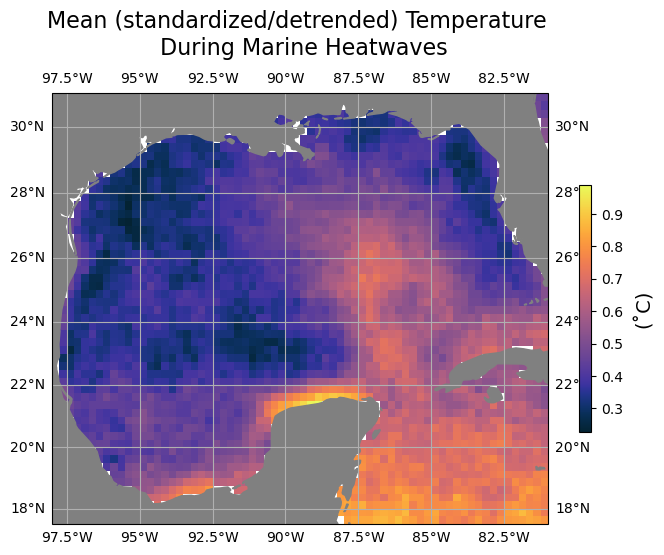

In [286]:
mhw_events = detrended_std.where(event_mask)
mean_mhw_temp = mhw_events.mean(dim="time")

cartopy_plot(mean_mhw_temp, cmocean.cm.thermal, '(˚C)', 
             'Mean (standardized/detrended) Temperature \n During Marine Heatwaves',);

Notable `da`'s:
- `events_by_grid_cell` : `{ (lat, lon): [(start_idx, end_idx), (start_idx, end_idx), ...] }`

> number of events

> mean event duration

> event statistics

- `event_mask` : `{time, lat, lon}`

> total MHW days

> mean temperature during events

> composites
- `mhw_events` : `{time, lat, lon}`

> temperature values on the days of MHW events (`nans` everything else)

> average MHW temperature, intensity metrics

In [11]:
#to count the # of events
event_mask_int = event_mask.astype(int) #0==False, 1==True

In [12]:
event_mask_int

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

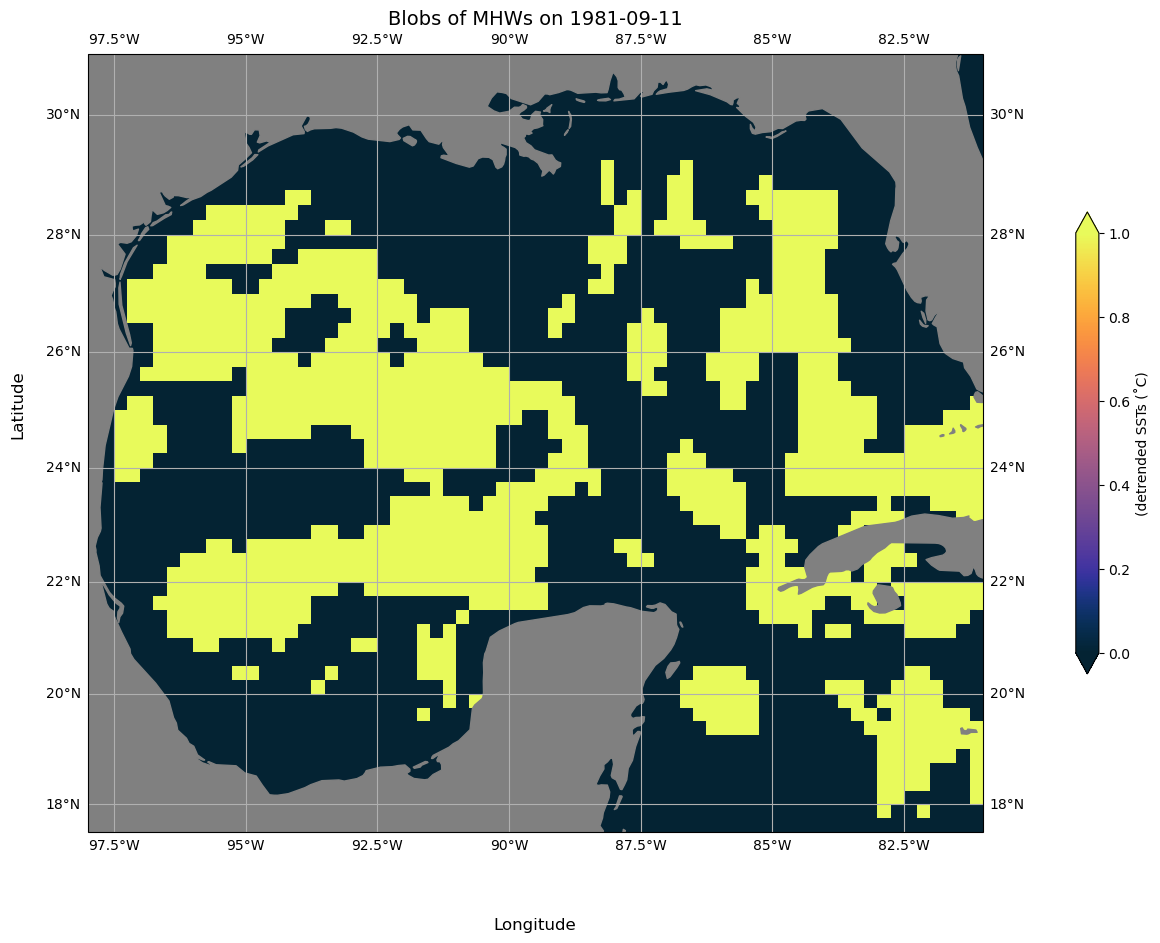

In [27]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
tt = 10 
da = event_mask_int.isel(time=tt)
im = ax.pcolormesh(da.lon, da.lat, da, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal)
cb = fig.colorbar(im, ax=ax, shrink=0.4, extend='both', pad=0.08)
cb.set_label("(detrended SSTs (˚C)")
#cb.ax.set_title(f"{units}", fontsize=10)# labelpad=2, loc='top')

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title(f'Blobs of MHWs on {event_mask_int.time[tt].dt.date.values}', fontsize=14);

In [35]:
# Count the number of days exceeding the 90th percentile in a specific year:
target_year_exceedances_d = event_mask_int.sel(time='1989').count()
print('Number of days exceeding the 90th percentile in \033[1m 1989 \033[0m:' + 
f'\033[1m{target_year_exceedances_d.item():,}\033[0m')

target_year_exceedances_d = event_mask_int.sel(time='2015').count()
print('Number of days exceeding the 90th percentile in \033[1m 2015: \033[0m' + 
f'\033[1m{target_year_exceedances_d.item():,}\033[0m')

Number of days exceeding the 90th percentile in  1989 :1,614,760
Number of days exceeding the 90th percentile in  2015: 1,614,760


In [36]:
# Count the number of days exceeding the 90th percentile in a specific year:
target_year_exceedances_d = exceedance_int_d.sel(time='2015').count()
print('Number of days exceeding the 90th percentile in \033[1m 2015 \033[0m:' + 
f'\033[1m{target_year_exceedances_d.item():,}\033[0m')

target_year_exceedances_d = exceedance_int_d.sel(time='1989').count()
print('Number of days exceeding the 90th percentile in \033[1m 1989: \033[0m' + 
f'\033[1m{target_year_exceedances_d.item():,}\033[0m')

Number of days exceeding the 90th percentile in  2015 :1,614,760
Number of days exceeding the 90th percentile in  1989: 1,614,760


In [29]:
event_mask_int[10]

<xarray.DataArray (lat: 56, lon: 79)> Size: 35kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
    time       datetime64[ns] 8B 1981-09-11
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  int64 8B 254

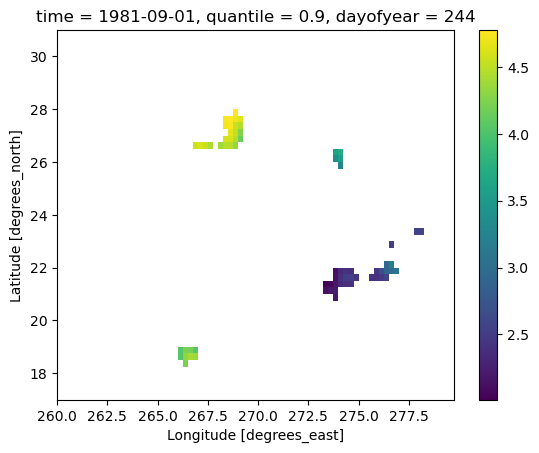

In [10]:
mhw_events[0].plot()

In [7]:
event_mask

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 71MB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

In [17]:
da_stacked.sel(grid_cells=(17.125, 260.125))

<xarray.DataArray (time: 16101)> Size: 129kB
array([0, 0, 0, ..., 0, 0, 0])
Coordinates:
  * time        (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
    quantile    float64 8B 0.9
    dayofyear   (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273
    grid_cells  object 8B (np.float32(17.125), np.float32(260.125))
    lat         float32 4B 17.12
    lon         float32 4B 260.1

In [15]:
da_stacked[0].grid_cells

<xarray.DataArray 'grid_cells' (grid_cells: 4424)> Size: 35kB
array([(17.125, 260.125), (17.125, 260.375), (17.125, 260.625), ...,
       (30.875, 279.125), (30.875, 279.375), (30.875, 279.625)], dtype=object)
Coordinates:
    time        datetime64[ns] 8B 1981-09-01
    quantile    float64 8B 0.9
    dayofyear   int64 8B 244
  * grid_cells  (grid_cells) object 35kB MultiIndex
  * lat         (grid_cells) float32 18kB 17.12 17.12 17.12 ... 30.88 30.88
  * lon         (grid_cells) float32 18kB 260.1 260.4 260.6 ... 279.4 279.6

In [11]:
ts

array([0, 0, 0, ..., 0, 0, 1])

In [12]:
events

[(182, 186),
 (222, 229),
 (261, 267),
 (305, 320),
 (337, 341),
 (382, 386),
 (446, 450),
 (479, 490),
 (734, 741),
 (890, 909),
 (1205, 1220),
 (1375, 1379),
 (1511, 1517),
 (1545, 1557),
 (1586, 1591),
 (1602, 1609),
 (1651, 1659),
 (1675, 1679),
 (1740, 1753),
 (1759, 1766),
 (1894, 1921),
 (1926, 1950),
 (1958, 1968),
 (2181, 2193),
 (2206, 2213),
 (2378, 2383),
 (2723, 2727),
 (3111, 3142),
 (3181, 3185),
 (3290, 3297),
 (3303, 3315),
 (3323, 3336),
 (3400, 3407),
 (3413, 3419),
 (3458, 3462),
 (3527, 3549),
 (3557, 3564),
 (3735, 3739),
 (3873, 3879),
 (4147, 4151),
 (4164, 4181),
 (4405, 4409),
 (4482, 4487),
 (4526, 4530),
 (4974, 4985),
 (5247, 5254),
 (5585, 5589),
 (5604, 5613),
 (5634, 5640),
 (5658, 5662),
 (6116, 6122),
 (6135, 6146),
 (6304, 6308),
 (6344, 6377),
 (6428, 6432),
 (6540, 6547),
 (7511, 7519),
 (7533, 7537),
 (7545, 7550),
 (7554, 7559),
 (7725, 7734),
 (7914, 7931),
 (8107, 8118),
 (8719, 8725),
 (8748, 8757),
 (8812, 8817),
 (9163, 9168),
 (9335, 9339),


In [10]:
time_coord

array(['1981-09-01T00:00:00.000000000', '1981-09-02T00:00:00.000000000',
       '1981-09-03T00:00:00.000000000', ...,
       '2025-09-28T00:00:00.000000000', '2025-09-29T00:00:00.000000000',
       '2025-09-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
event_mask

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 71MB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

In [8]:
mhw_events

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 1.85251356,
                nan,        nan],
        [       nan,        nan,        nan, ..., 1.93180052,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

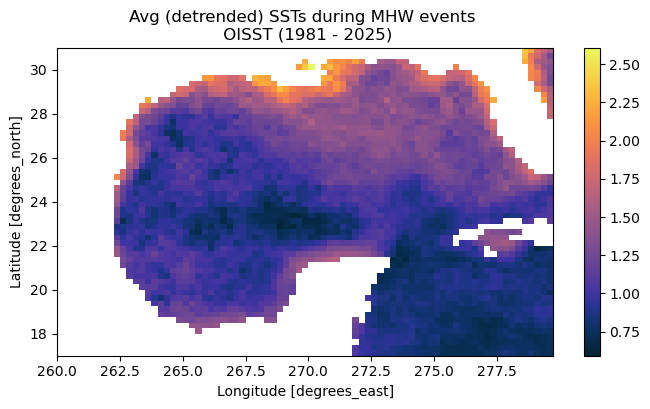

In [7]:
mhw_events.mean('time').plot(cmap=cmocean.cm.thermal, figsize=(8,4))
plt.title('Avg (detrended) SSTs during MHW events \n OISST (1981 - 2025)');

In [23]:
event_mask

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 71MB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

In [15]:
events_by_grid_cell

{(17.125, 271.875): [(85, 96),
  (101, 105),
  (121, 130),
  (155, 178),
  (182, 186),
  (498, 503),
  (518, 530),
  (550, 554),
  (573, 578),
  (581, 586),
  (633, 641),
  (669, 674),
  (678, 685),
  (693, 699),
  (776, 787),
  (810, 838),
  (841, 854),
  (943, 949),
  (952, 960),
  (1520, 1525),
  (1747, 1751),
  (1909, 1915),
  (1955, 1959),
  (2030, 2036),
  (2307, 2311),
  (2327, 2331),
  (2438, 2442),
  (2465, 2469),
  (2491, 2495),
  (2553, 2557),
  (2640, 2644),
  (3076, 3083),
  (3096, 3100),
  (3188, 3201),
  (3340, 3347),
  (3438, 3443),
  (3878, 3890),
  (4146, 4170),
  (4274, 4282),
  (4533, 4539),
  (4559, 4564),
  (4625, 4632),
  (4845, 4849),
  (4988, 4995),
  (5007, 5013),
  (5025, 5029),
  (5054, 5058),
  (5100, 5104),
  (5121, 5127),
  (5189, 5197),
  (5208, 5213),
  (5236, 5241),
  (5437, 5444),
  (5699, 5718),
  (5931, 5939),
  (5945, 5950),
  (6016, 6020),
  (6163, 6167),
  (6181, 6191),
  (6198, 6203),
  (6225, 6241),
  (7264, 7268),
  (7589, 7598),
  (7735, 7740

In [16]:
events

[(182, 186),
 (222, 229),
 (261, 267),
 (305, 320),
 (337, 341),
 (382, 386),
 (446, 450),
 (479, 490),
 (734, 741),
 (890, 909),
 (1205, 1220),
 (1375, 1379),
 (1511, 1517),
 (1545, 1557),
 (1586, 1591),
 (1602, 1609),
 (1651, 1659),
 (1675, 1679),
 (1740, 1753),
 (1759, 1766),
 (1894, 1921),
 (1926, 1950),
 (1958, 1968),
 (2181, 2193),
 (2206, 2213),
 (2378, 2383),
 (2723, 2727),
 (3111, 3142),
 (3181, 3185),
 (3290, 3297),
 (3303, 3315),
 (3323, 3336),
 (3400, 3407),
 (3413, 3419),
 (3458, 3462),
 (3527, 3549),
 (3557, 3564),
 (3735, 3739),
 (3873, 3879),
 (4147, 4151),
 (4164, 4181),
 (4405, 4409),
 (4482, 4487),
 (4526, 4530),
 (4974, 4985),
 (5247, 5254),
 (5585, 5589),
 (5604, 5613),
 (5634, 5640),
 (5658, 5662),
 (6116, 6122),
 (6135, 6146),
 (6304, 6308),
 (6344, 6377),
 (6428, 6432),
 (6540, 6547),
 (7511, 7519),
 (7533, 7537),
 (7545, 7550),
 (7554, 7559),
 (7725, 7734),
 (7914, 7931),
 (8107, 8118),
 (8719, 8725),
 (8748, 8757),
 (8812, 8817),
 (9163, 9168),
 (9335, 9339),


In [62]:
events_by_grid_cell[(17.125, 271.875)]

[(85, 96),
 (101, 105),
 (121, 130),
 (155, 178),
 (182, 186),
 (498, 503),
 (518, 530),
 (550, 554),
 (573, 578),
 (581, 586),
 (633, 641),
 (669, 674),
 (678, 685),
 (693, 699),
 (776, 787),
 (810, 838),
 (841, 854),
 (943, 949),
 (952, 960),
 (1520, 1525),
 (1747, 1751),
 (1909, 1915),
 (1955, 1959),
 (2030, 2036),
 (2307, 2311),
 (2327, 2331),
 (2438, 2442),
 (2465, 2469),
 (2491, 2495),
 (2553, 2557),
 (2640, 2644),
 (3076, 3083),
 (3096, 3100),
 (3188, 3201),
 (3340, 3347),
 (3438, 3443),
 (3878, 3890),
 (4146, 4170),
 (4274, 4282),
 (4533, 4539),
 (4559, 4564),
 (4625, 4632),
 (4845, 4849),
 (4988, 4995),
 (5007, 5013),
 (5025, 5029),
 (5054, 5058),
 (5100, 5104),
 (5121, 5127),
 (5189, 5197),
 (5208, 5213),
 (5236, 5241),
 (5437, 5444),
 (5699, 5718),
 (5931, 5939),
 (5945, 5950),
 (6016, 6020),
 (6163, 6167),
 (6181, 6191),
 (6198, 6203),
 (6225, 6241),
 (7264, 7268),
 (7589, 7598),
 (7735, 7740),
 (7745, 7752),
 (7860, 7873),
 (7877, 7881),
 (7909, 7914),
 (7966, 7970),
 (806

In [7]:
#da that retains temp above 90th percentile and associated coords 
exceedance_days_d

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 1.80490595,
         1.76289759,        nan],
        [       nan,        nan,        nan, ..., 1.85251356,
                nan,        nan],
        [       nan,        nan,        nan, ..., 1.93180052,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
         4.62997146, 4.01023181]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

In [8]:
#int boolean da where 1s=above90th, 0s=below90th
exceedance_int_d

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

In [8]:
# Count the number of days exceeding the 90th percentile in a specific year:
target_year_exceedances_d = exceedance_days_d.sel(time='2015').count()
print('Number of days exceeding the 90th percentile in \033[1m 2015 \033[0m:' + 
f'\033[1m{target_year_exceedances_d.item():,}\033[0m')

target_year_exceedances_d = exceedance_days_d.sel(time='2020').count()
print('Number of days exceeding the 90th percentile in \033[1m 2020: \033[0m' + 
f'\033[1m{target_year_exceedances_d.item():,}\033[0m')

Number of days exceeding the 90th percentile in  2015 :143,504
Number of days exceeding the 90th percentile in  2020: 139,549


In [9]:
# Example usage of criteria function
arr_example = [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1 ,1 ,1 ,1, 0]
events_example = find_events(arr_example)
print(events_example)
print('Interpretation: \nEvent 1: indices 1 → 6 (6 ones) \nEvent 2: indices 12 → 17 (6 ones)')

[(1, 6), (12, 17)]
Interpretation: 
Event 1: indices 1 → 6 (6 ones) 
Event 2: indices 12 → 17 (6 ones)


In [10]:
#need to map the `events` object back to exceedance_days_d array
#convert events array into int objects that can be used for slicing in consecutive_exceedances_5D_d array
slices = [slice(start, stop) for start, stop in events_example]
slices
[print(arr_example[sl]) for sl in slices]
#next step is to unravel the raveled array

[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]


[None, None]

## To Do (12-10-25 meeting): 
- stacked events bar plot
- Map of avg duration at each grid pt
- Map of total days
- Map of # events
- Map of avg temp anom during events

| Flattening Method                        | Basis        | Guarantee matches xarray? |
| ----------------------------- | ------------ | ------------------------- |
| `.ravel()`                    | memory order | ❌ no                      |
| `.reshape(-1)`                | memory order | ❌ no                      |
| `.transpose(...).reshape(-1)` | index order  | ✅ yes                     |
| `da.stack(...).values`        | index order  | baseline                  |


- - - 

- - - 

- - - 

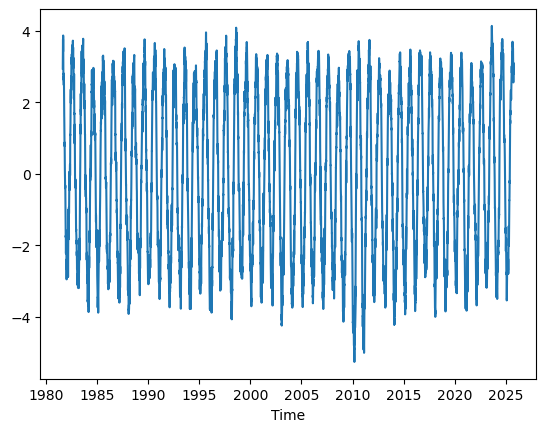

In [7]:
detrended_intime.mean(['lat','lon']).plot()

In [22]:
#example to see what stack is doing
time = pd.date_range("2000-01-01", periods=3)
lat = [10.0, 20.0, 30.0]
lon = [100.0, 110.0, 120.0]
data = np.random.rand(3, 3, 3)

da = xr.DataArray(
    data,
    dims=("time", "lat", "lon"),
    coords={"time": time, "lat": lat, "lon": lon},
    name="example")
da

<xarray.DataArray 'example' (time: 3, lat: 3, lon: 3)> Size: 216B
array([[[0.11535115, 0.81037585, 0.26775361],
        [0.44921086, 0.95392671, 0.63682148],
        [0.02158239, 0.56368967, 0.68340602]],

       [[0.47210071, 0.56393196, 0.17742844],
        [0.11959838, 0.07294198, 0.52086381],
        [0.90682956, 0.02416715, 0.92109226]],

       [[0.79329757, 0.64062588, 0.1983762 ],
        [0.67177728, 0.18846209, 0.08539544],
        [0.03855274, 0.56780966, 0.39308613]]])
Coordinates:
  * time     (time) datetime64[ns] 24B 2000-01-01 2000-01-02 2000-01-03
  * lat      (lat) float64 24B 10.0 20.0 30.0
  * lon      (lon) float64 24B 100.0 110.0 120.0

In [23]:
da_stacked = da.stack(points=("lat", "lon"))
da_stacked

<xarray.DataArray 'example' (time: 3, points: 9)> Size: 216B
array([[0.11535115, 0.81037585, 0.26775361, 0.44921086, 0.95392671,
        0.63682148, 0.02158239, 0.56368967, 0.68340602],
       [0.47210071, 0.56393196, 0.17742844, 0.11959838, 0.07294198,
        0.52086381, 0.90682956, 0.02416715, 0.92109226],
       [0.79329757, 0.64062588, 0.1983762 , 0.67177728, 0.18846209,
        0.08539544, 0.03855274, 0.56780966, 0.39308613]])
Coordinates:
  * time     (time) datetime64[ns] 24B 2000-01-01 2000-01-02 2000-01-03
  * points   (points) object 72B MultiIndex
  * lat      (points) float64 72B 10.0 10.0 10.0 20.0 20.0 20.0 30.0 30.0 30.0
  * lon      (points) float64 72B 100.0 110.0 120.0 100.0 ... 100.0 110.0 120.0

In [27]:
da_stacked = da.stack(points=("time", "lat", "lon"))
da_stacked

<xarray.DataArray 'example' (points: 27)> Size: 216B
array([0.11535115, 0.81037585, 0.26775361, 0.44921086, 0.95392671,
       0.63682148, 0.02158239, 0.56368967, 0.68340602, 0.47210071,
       0.56393196, 0.17742844, 0.11959838, 0.07294198, 0.52086381,
       0.90682956, 0.02416715, 0.92109226, 0.79329757, 0.64062588,
       0.1983762 , 0.67177728, 0.18846209, 0.08539544, 0.03855274,
       0.56780966, 0.39308613])
Coordinates:
  * points   (points) object 216B MultiIndex
  * time     (points) datetime64[ns] 216B 2000-01-01 2000-01-01 ... 2000-01-03
  * lat      (points) float64 216B 10.0 10.0 10.0 20.0 ... 20.0 30.0 30.0 30.0
  * lon      (points) float64 216B 100.0 110.0 120.0 100.0 ... 100.0 110.0 120.0

In [26]:
da_roundtrip = da_stacked.unstack("points")
print(da.identical(da_roundtrip))

True


- - - 

- - - 

- - - 

In [13]:
#test if ravel/tranpose methods yield same output at this step
np.array_equal(exceedance_int_d.values.ravel(),
               exceedance_int_d.transpose('time', 'lat', 'lon').values.reshape(-1))

True

In [19]:
#test if ravel/stack methods yield same output at this step
np.array_equal(exceedance_int_d.values.ravel(),
               exceedance_int_d.stack(z=('time', 'lat', 'lon')))

True

In [18]:
#test if transpose/stack methods yield same output at this step
np.array_equal(exceedance_int_d.transpose('time', 'lat', 'lon').values.reshape(-1),
               exceedance_int_d.stack(z=('time', 'lat', 'lon')))

True

In [13]:
#test if ravel/tranpose methods yield same output at this step
#np.array_equal outputs False even if nans are in the same place, so need to specify extra arg
np.array_equal(exceedance_days_d.values.ravel(),
               exceedance_days_d.transpose('time', 'lat', 'lon').values.reshape(-1),
               equal_nan=True)

True

In [14]:
arr = exceedance_int_d.values.ravel()
events = find_events(arr)
events #list of tuples and pairings of start/stop indices for each event that meets the criteria

[(416, 420),
 (493, 503),
 (569, 584),
 (648, 663),
 (728, 739),
 (811, 816),
 (1396, 1402),
 (1477, 1481),
 (1484, 1489),
 (1564, 1568),
 (3028, 3038),
 (3109, 3117),
 (3189, 3196),
 (3271, 3275),
 (4920, 4927),
 (4999, 5008),
 (5078, 5086),
 (5158, 5162),
 (5820, 5830),
 (5901, 5906),
 (5988, 5992),
 (7156, 7161),
 (7235, 7240),
 (7314, 7318),
 (7393, 7397),
 (7452, 7461),
 (7471, 7476),
 (7531, 7541),
 (7549, 7555),
 (7611, 7621),
 (7630, 7635),
 (7692, 7702),
 (7710, 7714),
 (7772, 7781),
 (7851, 7861),
 (7933, 7940),
 (8031, 8035),
 (9067, 9074),
 (9146, 9153),
 (9224, 9232),
 (9301, 9311),
 (9345, 9351),
 (9380, 9390),
 (9423, 9430),
 (9459, 9468),
 (9537, 9546),
 (9616, 9624),
 (9695, 9702),
 (9775, 9780),
 (9853, 9858),
 (9933, 9937),
 (10165, 10169),
 (10244, 10249),
 (10321, 10336),
 (10399, 10416),
 (10477, 10488),
 (10555, 10566),
 (10637, 10649),
 (10710, 10731),
 (10795, 10814),
 (10874, 10901),
 (10953, 10967),
 (10971, 10979),
 (11021, 11027),
 (11033, 11046),
 (11051, 

In [15]:
arr

array([0, 0, 0, ..., 0, 1, 1])

In [16]:
masked = np.full(arr.shape, np.nan) 
for start, stop in events:
    masked[start:stop] = arr[start:stop] #keep only event values

masked_temps = np.full(exceedance_days_d.values.ravel().shape, np.nan) 
for start, stop in events:
    masked_temps[start:stop] = exceedance_days_d.values.ravel()[start:stop] #keep only events' temp values

In [17]:
masked_temps.shape

(71230824,)

In [18]:
#test if unraveling works here
np.array_equal(exceedance_int_d, arr.reshape(*exceedance_int_d.shape))

True

In [19]:
masked_bool_3D = masked.reshape(*exceedance_int_d.shape)
masked_temp_3D = masked_temps.reshape(*exceedance_days_d.shape)

In [20]:
masked_bool_da = xr.DataArray(data=masked_bool_3D, coords={'time':exceedance_int_d.time, 
                                                           'lat':exceedance_int_d.lat,
                                                           'lon':exceedance_int_d.lon})
masked_temp_da = xr.DataArray(data=masked_temp_3D, coords={'time':exceedance_days_d.time, 
                                                           'lat':exceedance_days_d.lat,
                                                           'lon':exceedance_days_d.lon})

In [21]:
masked_bool_3D

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  1., nan, nan

In [22]:
masked_temp_da

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6

In [23]:
#Sum up all the days that exceed 90th/5-day/3-day threshold in each year
yrs_list = np.unique(masked_bool_da.time.dt.year)
exceedance_days_by_yr = []
for year in yrs_list:
    exceedance_days_by_yr.append(masked_bool_da.sel(time=f'{year}').count())

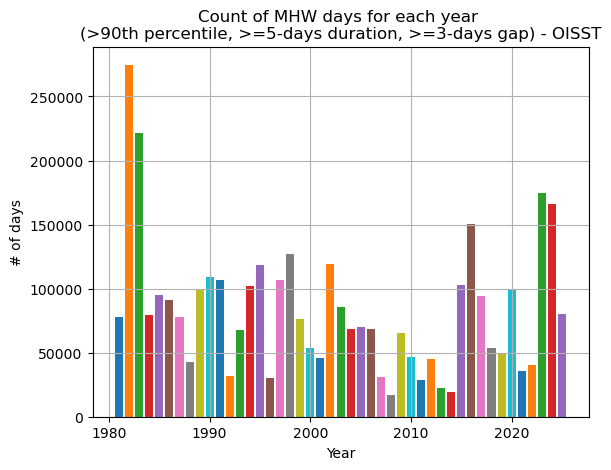

In [24]:
from tqdm import tqdm
#for i in tqdm(np.arange(0, len(events))):
#    plt.bar(i, events[i][-1] - events[i][0])
for (year, exc_days) in zip(yrs_list, exceedance_days_by_yr):
    plt.bar(year, exc_days)
plt.ylabel('# of days')
plt.xlabel('Year')
#plt.ylim(0, 600000)
#plt.xlim(1980, 2026)
plt.title('Count of MHW days for each year \n(>90th percentile, >=5-days duration, >=3-days gap) - OISST')
plt.grid();

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="year", y="MHW events", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [38]:
#Sum up all the days that exceed 90th/5-day threshold in each year
yrs_list = np.unique(masked_temp_da.time.dt.year)
exceedance_cumsum_by_yr = []
for year in yrs_list:
    exceedance_cumsum_by_yr.append(masked_temp_da.sel(time=f'{year}').count())

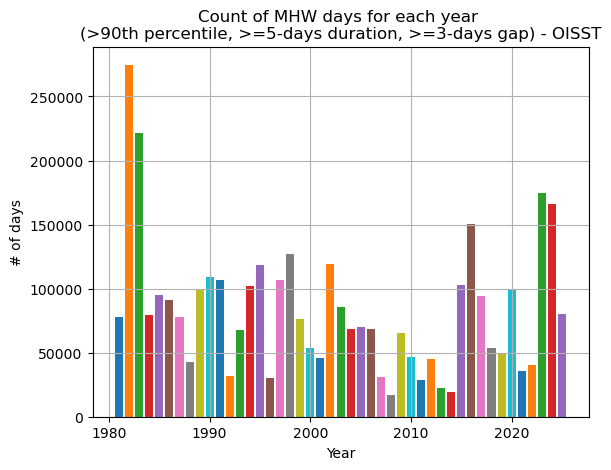

In [39]:
from tqdm import tqdm
#for i in tqdm(np.arange(0, len(events))):
#    plt.bar(i, events[i][-1] - events[i][0])
for (year, exc_days) in zip(yrs_list, exceedance_days_by_yr):
    plt.bar(year, exc_days)
plt.ylabel('# of days')
plt.xlabel('Year')
#plt.ylim(0, 600000)
#plt.xlim(1980, 2026)
plt.title('Count of MHW days for each year \n(>90th percentile, >=5-days duration, >=3-days gap) - OISST')
plt.grid();

In [100]:
nan_array = np.full(exceedance_int_d.shape, np.nan)
nan_arr_flat = nan_array.ravel()
nan_arr_flat

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
nan_arr_flat[:] = events

In [91]:
arr_index = np.arange(0, len(arr))

In [95]:
arr_index[416:420]

array([416, 417, 418, 419])

In [ ]:
arr

**Goals:**
1. Duration count for each event (bar plot)
> Map it back to get time coords
2. Identify the temperatures for each event (line/bar plot)

In [55]:
slices = [slice(start, stop) for start, stop in events[:1]]
slices
[print(arr[sl]) for sl in slices]

[1 1 1 1]


[None]

In [59]:
slices

[slice(416, 420, None)]

In [57]:
slice(events[0])

slice(None, (416, 420), None)

In [25]:
events[:3]

[(416, 420), (493, 503), (569, 584)]

In [26]:
eventID = [i for i, _ in enumerate(events)] #same len as `events`

In [27]:
eventID

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [28]:
events

[(416, 420),
 (493, 503),
 (569, 584),
 (648, 663),
 (728, 739),
 (811, 816),
 (1396, 1402),
 (1477, 1481),
 (1484, 1489),
 (1564, 1568),
 (3028, 3038),
 (3109, 3117),
 (3189, 3196),
 (3271, 3275),
 (4920, 4927),
 (4999, 5008),
 (5078, 5086),
 (5158, 5162),
 (5820, 5830),
 (5901, 5906),
 (5988, 5992),
 (7156, 7161),
 (7235, 7240),
 (7314, 7318),
 (7393, 7397),
 (7452, 7461),
 (7471, 7476),
 (7531, 7541),
 (7549, 7555),
 (7611, 7621),
 (7630, 7635),
 (7692, 7702),
 (7710, 7714),
 (7772, 7781),
 (7851, 7861),
 (7933, 7940),
 (8031, 8035),
 (9067, 9074),
 (9146, 9153),
 (9224, 9232),
 (9301, 9311),
 (9345, 9351),
 (9380, 9390),
 (9423, 9430),
 (9459, 9468),
 (9537, 9546),
 (9616, 9624),
 (9695, 9702),
 (9775, 9780),
 (9853, 9858),
 (9933, 9937),
 (10165, 10169),
 (10244, 10249),
 (10321, 10336),
 (10399, 10416),
 (10477, 10488),
 (10555, 10566),
 (10637, 10649),
 (10710, 10731),
 (10795, 10814),
 (10874, 10901),
 (10953, 10967),
 (10971, 10979),
 (11021, 11027),
 (11033, 11046),
 (11051, 

In [29]:
masked_temps

array([nan, nan, nan, ..., nan, nan, nan])

In [30]:
masked_temp_da

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6

In [34]:
#test if stack method yields same output as original flattening using ravel
np.array_equal(masked_temp_da.stack(z=('time', 'lat', 'lon')), masked_temp_da.values.ravel(), 
               equal_nan=True)

True

In [35]:
#how to flatten masked_temp_da and retain time dim associated w each grid cell
flattened = masked_temp_da.stack(z=('time', 'lat', 'lon'))

values = flattened.values # flattened numerical data
event_time_coord = flattened['z'] # MultiIndex with (time, lat, lon)

In [40]:
flattened

<xarray.DataArray (z: 71230824)> Size: 570MB
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * z        (z) object 570MB MultiIndex
  * time     (z) datetime64[ns] 570MB 1981-09-01 1981-09-01 ... 2025-09-30
  * lat      (z) float32 285MB 17.12 17.12 17.12 17.12 ... 30.88 30.88 30.88
  * lon      (z) float32 285MB 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6

In [46]:
event_time_coord

<xarray.DataArray 'z' (z: 71230824)> Size: 570MB
array([(Timestamp('1981-09-01 00:00:00'), 17.125, 260.125),
       (Timestamp('1981-09-01 00:00:00'), 17.125, 260.375),
       (Timestamp('1981-09-01 00:00:00'), 17.125, 260.625), ...,
       (Timestamp('2025-09-30 00:00:00'), 30.875, 279.125),
       (Timestamp('2025-09-30 00:00:00'), 30.875, 279.375),
       (Timestamp('2025-09-30 00:00:00'), 30.875, 279.625)], dtype=object)
Coordinates:
  * z        (z) object 570MB MultiIndex
  * time     (z) datetime64[ns] 570MB 1981-09-01 1981-09-01 ... 2025-09-30
  * lat      (z) float32 285MB 17.12 17.12 17.12 17.12 ... 30.88 30.88 30.88
  * lon      (z) float32 285MB 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6

In [36]:
values

array([nan, nan, nan, ..., nan, nan, nan])

In [38]:
#test to be sure
np.array_equal(masked_temps, values, equal_nan=True)

True

In [41]:
len(values)

71230824

In [43]:
len(event_time_coord)

71230824

In [44]:
len(masked_temps)

71230824

In [ ]:
#time-year; temps; event ID
df = pd.DataFrame({
    "time": event_time_coord,
    "event_id": eventID,
    "temp": masked_temp
})

100%|██████████| 367388/367388 [04:36<00:00, 1330.20it/s]


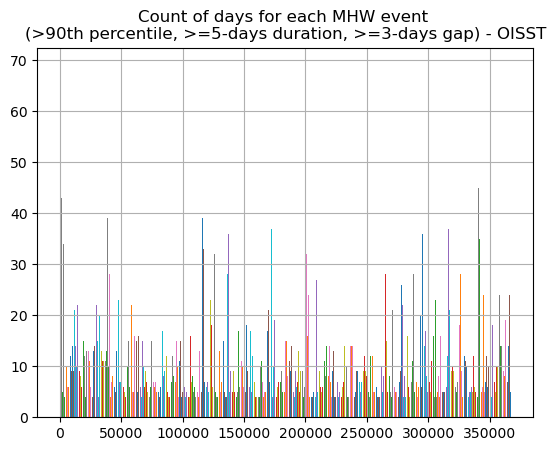

In [40]:
from tqdm import tqdm
for i in tqdm(np.arange(0, len(events))):
    plt.bar(i, events[i][-1] - events[i][0])
plt.title('Count of days for each MHW event \n(>90th percentile, >=5-days duration, >=3-days gap) - OISST')
plt.grid();
#Each event does not exceed 50 days - don't know when/where these events occur though

In [26]:
arr_example

[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]

In [28]:
exceedance_int_d

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

In [30]:
arr

array([0, 0, 0, ..., 0, 1, 1])

In [34]:
#check if unraveling this way outputs original array
np.array_equal(exceedance_int_d, arr.reshape(*exceedance_int_d.shape))

True

In [22]:
#Absolute Temp block
#Group by day of the year and then calculate the 90th percentile
da = oisst_ds.sst.sel(lon=slice(None, 279.625)).groupby('time.dayofyear')
baseline_p90 = da.quantile(0.9, dim='time')

#reindex the baseline_p90 to match the full dataset's dayofyear
current_p90_threshold = baseline_p90.sel(dayofyear=oisst_ds.time.dt.dayofyear)

#Identify days where current temperature exceeds the 90th percentile baseline
exceedance_days = oisst_ds.sst.where(oisst_ds.sst > current_p90_threshold)
#Make boolean mask of days that exceed 90th percentile
exceedance_mask_bool = (oisst_ds.sst > current_p90_threshold)
#Make boolean mask int to count days for 5-day threshold
exceedance_int = exceedance_mask_bool.astype(int)
#Identify the events that are >=5 days
consecutive_exceedances_5D = exceedance_int.rolling(time=5, center=False).sum()
exceedance_periods_5D = consecutive_exceedances_5D >= 5
consecutive_exceedances_30D = exceedance_int.rolling(time=30, center=False).sum()
exceedance_periods_30D = consecutive_exceedances_30D >= 30

# Count the number of days exceeding the 90th percentile in a specific year:
target_year_exceedances = exceedance_days.sel(time='2015').count()
print('Number of days exceeding the 90th percentile in \033[1m 2015 \033[0m:' + 
f'\033[1m{target_year_exceedances.item():,}\033[0m')

target_year_exceedances = exceedance_days.sel(time='2020').count()
print('Number of days exceeding the 90th percentile in \033[1m 2020: \033[0m' + 
f'\033[1m{target_year_exceedances.item():,}\033[0m')

Number of days exceeding the 90th percentile in  2015 :218,905
Number of days exceeding the 90th percentile in  2020: 299,701


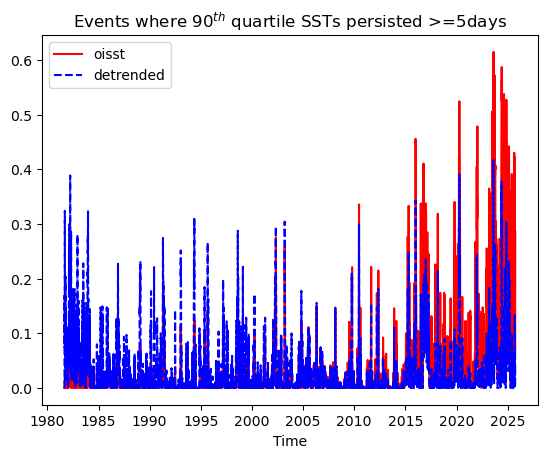

In [23]:
exceedance_periods_5D.mean(['lat', 'lon']).plot(label='oisst', color='r')
exceedance_periods_5D_d.mean(['lat', 'lon']).plot(label='detrended', color='b', linestyle='dashed')
plt.legend()
plt.title('Events where 90$^{th}$ quartile SSTs persisted >=5days');

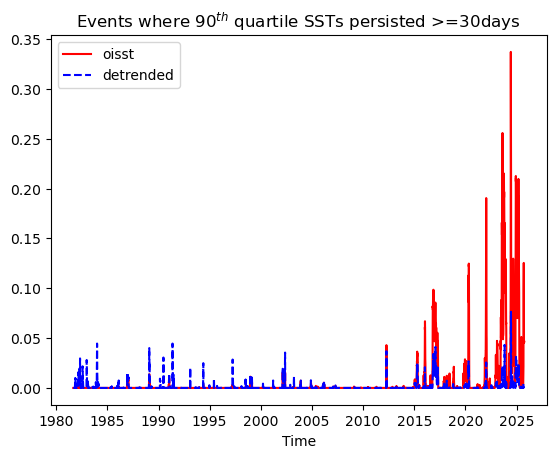

In [24]:
exceedance_periods_30D.mean(['lat', 'lon']).plot(label='oisst', color='r')
exceedance_periods_30D_d.mean(['lat', 'lon']).plot(label='detrended', color='b', linestyle='dashed')
plt.legend()
plt.title('Events where 90$^{th}$ quartile SSTs persisted >=30days');

In [25]:
#Sum up all the days that exceed 90th/5-day threshold in each year
yrs_list = np.unique(exceedance_days.time.dt.year)
exceedance_days_by_yr = []
for year in yrs_list:
    exceedance_days_by_yr.append(exceedance_days.sel(time=f'{year}').count())

In [26]:
exceedance_days.sel(time='2012').count()

<xarray.DataArray 'sst' ()> Size: 8B
array(100532)
Coordinates:
    quantile  float64 8B 0.9

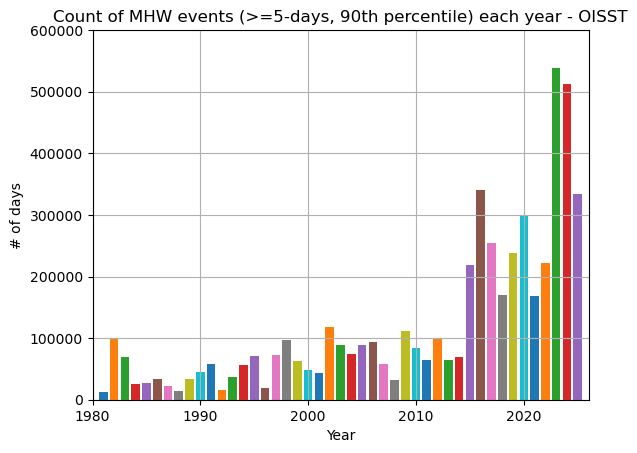

In [27]:
for (year, exc_days) in zip(yrs_list, exceedance_days_by_yr):
    plt.bar(year, exc_days)
plt.ylabel('# of days')
plt.xlabel('Year')
plt.ylim(0, 600000)
plt.xlim(1980, 2026)
plt.title('Count of MHW events (>=5-days, 90th percentile) each year - OISST')
plt.grid();

In [66]:
#Sum up all the days that exceed 90th/5-day threshold in each year
yrs_list = np.unique(event_id.time.dt.year)
exceedance_events_by_yr = []
for year in yrs_list:
    exceedance_events_by_yr.append(event_id.sel(time=f'{year}').count())

In [80]:
format(event_id.sel(time='2015').count(), ",") 

'1,614,760'

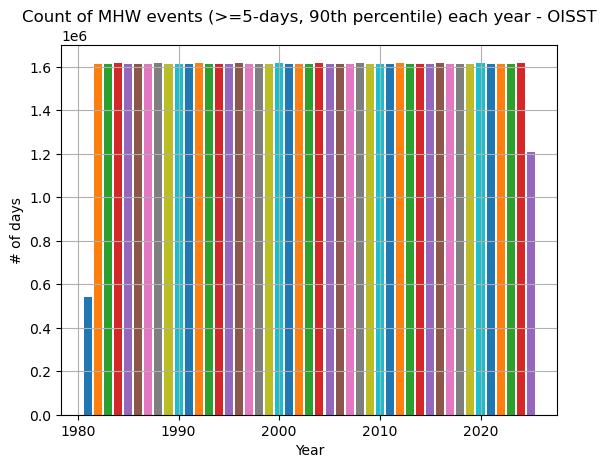

In [82]:
for (year, exc_events) in zip(yrs_list, exceedance_events_by_yr):
    plt.bar(year, exc_events)
plt.ylabel('# of days')
plt.xlabel('Year')
#plt.ylim(0, 600000)
#plt.xlim(1980, 2026)
plt.title('Count of MHW events (>=5-days, 90th percentile) each year - OISST')
plt.grid();

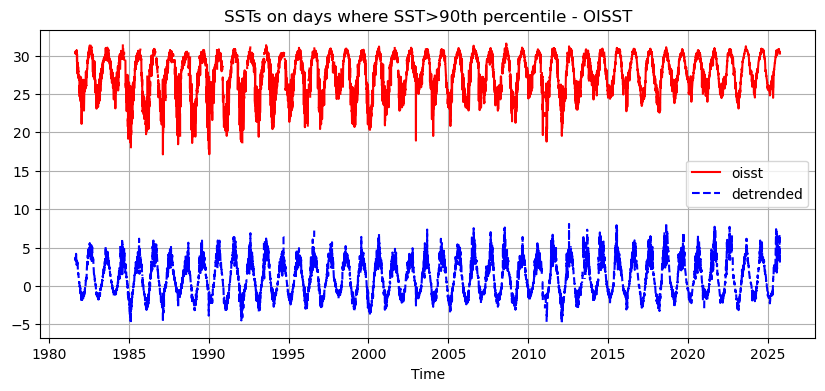

In [30]:
exceedance_days.mean(['lat', 'lon']).plot(label='oisst', color='r', figsize=(10,4))
exceedance_days_d.mean(['lat', 'lon']).plot(label='detrended', color='b', linestyle='dashed')
plt.grid()
#plt.ylim(17,32)
plt.title('SSTs on days where SST>90th percentile - OISST')
plt.legend(loc='best');